<a href="https://colab.research.google.com/github/anasnafis77/Deteksi-Glaukoma/blob/main/Kode/Deteksi%20Glaukoma.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [20]:
import pandas as pd

df = pd.read_json('/content/gdrive/My Drive/Drive Tugas Akhir/Kode/dataframe.json')

In [ ]:
df.to_json('/content/gdrive/My Drive/Drive Tugas Akhir/Kode/dataframe.json')

In [21]:
filename = '/content/gdrive/My Drive/Drive Tugas Akhir/Kode/ROItemplate.png'
template_image = cv2.imread(filename, 0)

In [ ]:
#make image template

plt.rcParams["figure.figsize"] = (5,5)

template_image = np.zeros([551, 551], np.float32)
for i in range(100):
    src = cv2.imread(df['path'][i], 1)
    src = src[:,:,1]
    temp, _ = ekstrakROI(df['disc_center'][i], 550, src)
    template_image += temp

template_image = ((template_image)/100)
template_image = np.uint8(template_image)

filename = '/content/gdrive/My Drive/Drive Tugas Akhir/Kode/ROItemplate.png'
cv2.imwrite(filename, template_image)
print(template_image.dtype)
plt.imshow(template_image, cmap = 'gray')
plt.show()

NameError: ignored

# Semua Fungsi Algoritma

In [2]:
import cv2
import csv
import math 
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt 
from tqdm.notebook import tqdm
from skimage.segmentation import slic
from skimage.segmentation import mark_boundaries
import random 
from ipywidgets import interact
from sklearn.preprocessing import Normalizer
import pickle
from skimage.segmentation import active_contour
from skimage.filters import gaussian
from skimage.transform import hough_ellipse
from skimage.draw import ellipse_perimeter
import time
from sklearn.decomposition import PCA
from sklearn import svm
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [3]:
# menampilkan gambar
def figure(images, title, coloumn = 3, size = 20):
    
    plt.rcParams["figure.figsize"] = (size,size) #memperbesar gambar
    

    if (len(images) < 3):
      col = len(images)
    else:
      col = coloumn*1

    row = math.ceil(len(images)/col)

    for a in range(len(images)):
      plt.subplot(row,col, a+1), plt.imshow(images[a], cmap = 'gray')
      plt.title(title[a])
      plt.xticks([]), plt.yticks([])
    plt.show()

In [ ]:
# merubah GT drishti menjadi citra mask ground truth
def drishtiGT(path, shape):

  file = open(path, 'r')
  coordinates = file.readlines()
  h, w, _ = shape

  # Ekstrak koordinat dari file gt drishti
  for i in range(len(coordinates)):
    y, x = coordinates[i].split(" ")
    coordinates[i] = (int(x), int(y))

  coordinates = np.array(coordinates)
  file.close()

  # inisiasi citra mask ground truth

  mask = np.zeros([h, w], np.uint8)
  mask[coordinates[:, 1],coordinates[:, 0]] = 255
  color = 255
  mask_contour, hierarchy = cv2.findContours(mask, 
  cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
  mask = np.zeros([h, w], np.uint8)
  # menggambar boundary mask dari data coordinate gt drishti

  cv2.drawContours(mask, mask_contour, -1, color, cv2.FILLED)

  return mask

path = '/content/gdrive/My Drive/Drive Tugas Akhir/Dataset/Drishti/Drishti-GS1_files/Test/Test_GT/Normal/drishtiGS_007/AvgBoundary/drishtiGS_007_ODAvgBoundary.txt'
full_path = '/content/gdrive/My Drive/Drive Tugas Akhir/Dataset/Drishti/Drishti-GS1_files/Test/Images/Normal/drishtiGS_007.png'
shape = cv2.imread(full_path).shape
mask = drishtiGT(path, shape)
plt.imshow(mask, cmap='gray')
plt.show()

In [5]:
# fungsi untuk mengkonversi groundtruth REFUGE
def refuGT(path):


  #coming soon
  mask = cv2.imread(path, 0)
  h, w = mask.shape

  #inisialisasi bound
  OD_mask = np.zeros([h, w], np.uint8)
  OC_mask = np.zeros([h, w], np.uint8)

  OD_mask[mask==128] = 255
  OC_mask[mask==0] = 255

  OD_mask = OD_mask + OC_mask



  return OD_mask, OC_mask


In [6]:
def maxima(d_img):
# Input : distance map 
# output : max point map (maxima) 
  height, width = d_img.shape

  maxima = np.zeros(d_img.shape, dtype = int)
  th = d_img.max()/2
  maxima[d_img > th] = 255

  return maxima

In [7]:
def centroids(maxima):
  # mencari centroid dari setiap blob maxima
  centroids = []
  contours, hierarchy  = cv2.findContours(maxima,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
  for c in contours:
    # calculate moments for each contour
    M = cv2.moments(c)
    # calculate x,y coordinate of center
    if M["m00"] != 0:
      cX = int(M["m10"] / M["m00"])
      cY = int(M["m01"] / M["m00"])
    else:
      cX, cY = 0, 0
    p = [cX, cY]
    centroids.append(p)


  return centroids


In [8]:
# put circle in bright region of retinal image
def brightspot (centroid, img, c=None):
  image = img.copy()
  for i in range(len(centroid)):
    image = cv2.circle(image, (centroid[i][0], centroid[i][1]) , 5, (255, 255, 255), -1)
    if i == c:
      cv2.putText(image, "brightspot", (centroid[i][0] - 25, centroid[i][1] - 25),cv2.FONT_HERSHEY_SIMPLEX,3, (255, 255, 255), 4)
    else:
      cv2.putText(image, "brightspot", (centroid[i][0] - 25, centroid[i][1] - 25),cv2.FONT_HERSHEY_SIMPLEX,1, (255, 255, 255), 2)

  return image

In [9]:
# Fungsi untuk menyocokan histogram
# input : list koordinat centroid, panjang sisi ROI, citra retina asli, 
# template histogram
# output : koordinat centroid yang diduga centroid dari Optic Disc
def histogram_template_matching(centroids, s, img, hist_temp):
  corr_max = -999
  center = [0,0]
  h, w = img.shape
  hist_temp = np.array(hist_temp)
  for i in range(len(centroids)):
    x = centroids[i][0]
    y = centroids[i][1]
    
    centroid = (x, y)
    
    #cropping ROI from source image
    ROI, _ = ekstrakROI(centroid, s, img)

    # Green channel histogram, 0 : red, 1 : green, 2 : blue
    hist = cv2.calcHist(ROI, [1], None, [256], [0,256])
    hist = np.array(hist)
    
    #calc correlation formula
    
    diff = (hist/max(hist)) - (hist_temp/max(hist_temp))
    diff = diff**2
    diff = np.sum(diff)
    corr = 1/(1+diff)
    
    if corr > corr_max :
      corr_max = corr
      center[0] = x
      center[1] = y
  
  return center

In [10]:
# Fungsi untuk mengekstrak ROI
# input : list centroid, panjang sisi ROI (s), dan image 
# output : ROI image


def ekstrakROI(centroid, s, img):
  try:
    h, w, _ = img.shape
  except:
    h, w = img.shape
  x = centroid[0]
  y = centroid[1]
  x0 = round(x - 0.5*s)
  x1 = round(x + 0.5*s)
  y0 = round(y - 0.5*s)
  y1 = round(y + 0.5*s)

  # penanganan kasus out of image
  if (x0 < 0):
    x1 = x1 + (-x0)
    x0 = x0 + (-x0)
  elif (x1 > w-1):
    x0 = x0 - (x1-(w-1))
    x1 = x1 - (x1-(w-1))

  if (y0 < 0):
    y1 = y1 + (-y0)
    y0 = y0 + (-y0)
  elif (y1 > h-1):
    y0 = y0 - (y1-(h-1))
    y1 = y1 - (y1-(h-1))

  #cropping ROI from source image
  ROI = img[y0:y1+1, x0:x1+1]
  koordinat = (y0, y1, x0, x1)

  return ROI, koordinat

In [11]:
# Circle Hough Transform Model fitting
def CircleHoughTransform(mask):
  
  gray = cv2.GaussianBlur(mask, (5, 5),0)

  #inisiasi output circle hough transform
  mask_hough = np.zeros(mask.shape, np.uint8)
  
  rows = gray.shape[0]
  circles = cv2.HoughCircles(gray, cv2.HOUGH_GRADIENT, 1, rows/2,
                               param1=100, param2=10,
                               minRadius=100, maxRadius=600)

  # memastikan paling tidak ada satu lingkaran yang terdeteksi
  try: 
    if circles is not None:
      circles = np.round(circles[0, :]).astype("int")
    
      # inisialisasi jarak dan parameter lingkaran
      min_jarak = 9999
      circle = (0,0,0)
      xc, yc = 300, 300
      # seleksi lingkaran dengan jarak pusat lingkaran
      # yang paling dekat dengan titik tengah ROI
      for (x, y, r) in circles:
        jarak = (x - xc)**2 + (y - yc)**2
        if jarak < min_jarak:
          circle = x, y, r
          min_jarak = jarak

      Xc, Yc, R = circle

      cv2.circle(mask_hough, (Xc, Yc), R, 255, thickness = cv2.FILLED)
 
  except:
      mask_hough = mask

  return mask_hough

In [12]:
# fungsi untuk segmentasi OC dan OD mvoulana et al
# Input : Region of Interest of OD
# Output : mask of OD dan OC
def segmentasi_OC_OD_kmeans(ROI):
  # Reshaping the image into a 2D array of pixels and 1 color values (Grayscale)
  pixel_vals = ROI.reshape((-1,1)) 
  

  # Convert to float type 
  pixel_vals = np.float32(pixel_vals)

  #the below line of code defines the criteria for the algorithm to stop running,  
  #which will happen is 100 iterations are run or the epsilon (which is the required accuracy)  
  #becomes 85% 
  criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 150, 0.95) 
    
  # then perform k-means clustering wit h number of clusters defined as 3 
  #also random centres are initally chosed for k-means clustering 
  k = 5 # dari mvoulana
  retval, labels, centers = cv2.kmeans(pixel_vals, k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS) 

  # convert data into 8-bit values 
  centers = np.uint8(centers)
  segmented_data = centers[labels.flatten()] 
  
  # reshape data into the original image dimensions 
  segmented_image = segmented_data.reshape((ROI.shape)) 
  
  # mengambil label dengan nilai value tertinggi pertama dan kedua
  
  centers.sort()
  max_value = max(centers)
  min_value = min(centers)
  second_value = -999
  for i in range(len(centers)):
    if second_value < centers[i] and max_value > centers[i] :
      second_value = centers[i]
  
  first_label = np.where(centers == max_value)[0]
  second_label = np.where(centers == second_value)[0]
  # last_label = np.where(centers == min_value)[0]

  #inisisasi mask OD dan OC
  OD_kmeans = np.zeros(ROI.shape, np.uint8)
  OC_kmeans = np.zeros(ROI.shape, np.uint8)

  # Vessel_mask = np.zeros(ROI.shape, np.uint8)


  labels = labels.reshape((ROI.shape))
  # Mengisi mask OD dan OC 
  h, w = ROI.shape

  OC_kmeans[labels == first_label] = 255
  OD_kmeans[labels == second_label] = 255

  
  OD_kmeans = OD_kmeans + OC_kmeans


  # operasi morfologi
  kernel =  cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(10,10))
  OC_mask = cv2.erode(OC_kmeans, kernel,iterations = 1)
  OD_mask = cv2.erode(OD_kmeans, kernel, iterations = 1)

  OC_mask = cv2.dilate(OC_mask,kernel, iterations = 1)
  OD_mask = cv2.dilate(OD_mask, kernel, iterations = 1)

  OC_mask = cv2.erode(OC_mask, kernel,iterations = 1)
  OD_mask = cv2.erode(OD_mask, kernel, iterations = 1)

  OC_mask = cv2.dilate(OC_mask,kernel, iterations = 1)
  OD_mask = cv2.dilate(OD_mask, kernel, iterations = 1)

  #kernel =  cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(80,80))
  #OC_mask = cv2.morphologyEx(OC_mask, cv2.MORPH_CLOSE, kernel)
  #OD_mask = cv2.morphologyEx(OD_mask, cv2.MORPH_CLOSE, kernel)

  # Convex hull
  OD = OD_mask.copy()
  OC = OC_mask.copy()
  contoursOD, hierarchyOD = cv2.findContours(OD, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
  contoursOC, hierarchyOC = cv2.findContours(OC, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
  
  OD_convexhull = np.zeros([h, w], np.uint8)
  OC_convexhull = np.zeros([h, w], np.uint8)

  for i in range(len(contoursOD)):
    color = 255
    contoursOD[i] = cv2.convexHull(contoursOD[i], False)
    
    # seleksi contour 
    centers, radius = cv2.minEnclosingCircle(contoursOD[i])
    min_Rad = 50
    if (radius > min_Rad):
      cv2.drawContours(OD_convexhull, contoursOD, i, color, thickness = cv2.FILLED)

  for i in range(len(contoursOC)):
    color = 255
    contoursOC[i] = cv2.convexHull(contoursOC[i], False)
    
    # seleksi contour 
    centers, radius = cv2.minEnclosingCircle(contoursOC[i])
    min_Rad = 25
    if (radius > min_Rad):
      cv2.drawContours(OC_convexhull, contoursOC, i, color, thickness = cv2.FILLED)

  # Circle Hough Transform
  OD_circle = CircleHoughTransform(OD_convexhull)
  OC_circle = CircleHoughTransform(OC_convexhull)

  return OD_circle, OC_circle



In [13]:
def drawMask(mask, src, tipe):

  source  = src.copy()
  idx = np.where(mask == 255)
  idx = list(zip(*idx))
  idx = np.array(idx)

  if tipe == 'kuning':
    source[idx[:, 0], idx[:, 1],0] = 0 #R
    source[idx[:, 0], idx[:, 1],1] = 255 #G
    source[idx[:, 0], idx[:, 1],2] = 255 #B

  elif tipe =='biru':
    source[idx[:, 0], idx[:, 1],0] = 0 #R
    source[idx[:, 0], idx[:, 1],1] = 0 #G
    source[idx[:, 0], idx[:, 1],2] = 255 #B

  elif tipe == 'hijau':
    source[idx[:, 0], idx[:, 1],0] = 0 #B
    source[idx[:, 0], idx[:, 1],1] = 255 #G
    source[idx[:, 0], idx[:, 1],2] = 0 #R

  elif tipe == 'merah':
    source[idx[:, 0], idx[:, 1],0] = 255 #R
    source[idx[:, 0], idx[:, 1],1] = 0 #G
    source[idx[:, 0], idx[:, 1],2] = 0 #B

  elif tipe == None:
    source[idx[:, 0], idx[:, 1],0] = 0 #B
    source[idx[:, 0], idx[:, 1],1] = 255 #G
    source[idx[:, 0], idx[:, 1],2] = 255 #R

  return source

In [14]:
# mengembalikan size Mask OC dan OD menjadi size citra awal
def resizeMask(koordinat, shape, mask):
  yo, yi, xo, xi = koordinat

  mask_temp = np.zeros(shape, np.uint8)

  for y in range(yo, yi):
    for x in range(xo, xi):
      if mask[y-yo][x-xo] == 255:
        mask_temp[y][x] = 255

  return mask_temp

In [15]:
# Fungsi untuk mengekstrak TP, TN, FP, FN dari input yang berbeda
# input : ground truth dan prediksi. kedua objek tersebut harus sama sizenya (uint8)
# output : TP, TN, FP, FN

def checkROI(OD, center):
  # tipe adalah pembeda cara ekstrak TP, TN, FP, dan FN berbentuk int (1,2,3)
  # tipe : 1. OD detection, 2. segmentasi , 3. screening glaucoma

  # print('coming soon')
  batas = 90
  luasgtAsli = np.sum(OD==255)
  _, (y0, y1, x0, x1) = ekstrakROI(center, 600, OD)
  luasgtROI = np.sum(OD[y0:y1+1, x0:x1+1]==255)
  presentasi = (luasgtROI/ luasgtAsli) * 100

  if presentasi >= batas:
      return True, presentasi
  else:
      return False, presentasi


  


In [16]:
# kalkulasi metrik 
def MetricCalc (gt, pred, tipe):
  # tipe adalah pembeda cara ekstrak TP, TN, FP, dan FN berbentuk int (1,2,3)
  # tipe : 1. untuk OD detection, 2. untuk segmentasi , 3. screening glaucoma
  TP, TN, FP, FN = hitungPred(gt, pred, tipe)

  metrik = {"sen": (TP, (TP+FN)) , "PPV": (TP, TP + FP ), "Fscore" : ((2*TP), (2*TP + FP + FN)), 
            "spe" : ( TN, (TN + FP)), "NPV" : (TN, (TN + FN)),
            "Acc" : ((TP + FN) , ( TP + TN + FP + FN))}

  for hasil in metrik:
    num, denum = metrik[hasil]
    if denum == 0:
      metrik[hasil] = 0
    else :
      metrik[hasil] = round(num/denum, 2)

  return metrik["Fscore"]

In [17]:
def centerofmass(mask):
    contours, _  = cv2.findContours(mask,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
 
    # calculate moments for each contour
    M = cv2.moments(contours[0])
    # calculate x,y coordinate of center
    if M["m00"] != 0:
        cX = int(M["m10"] / M["m00"])
        cY = int(M["m01"] / M["m00"])
    
    return (cX, cY)

In [92]:
def differenceMap(ROI):
  # Membuat 18 Difference map dari ROI
  ROI_rgb = [ROI[:,:,0],ROI[:,:,1], ROI[:,:,2]]
  map = []
  for i in range(3):
    G = ROI_rgb[i].copy()
    gpA = [G]
    for i in range(8):
      G = cv2.pyrDown(G)
      gpA.append(G)


    C = [1,2,3]
    D = [3, 4]
    for c in C:
      for d in D:
        s = c + d
        h, w = gpA[c].shape[0], gpA[c].shape[1]
        fs_c = cv2.resize(gpA[s], (h, w), interpolation = cv2.INTER_NEAREST)
      
        m = abs(gpA[c] - fs_c)
        #resize maps back to original size
        m = cv2.resize(m, (ROI.shape[0], ROI.shape[1]), interpolation = cv2.INTER_NEAREST)
        map.append(m)
  
  return map

def extractTag(gt_OD, mask):
    percentage = np.sum(gt_OD[mask==255])/ np.sum(mask==255) * 100
    if percentage >= 98 :
      tag = 1 #daerah OD
    else:
      tag = -1 #daerah non OD

    return tag

def extractHistSP(label, images,segments):
    mask = np.zeros((images[0].shape[0], images[0].shape[1]),np.uint8)
    mask[segments==label] = 255
    HIST_map = np.zeros((5, 256), np.uint8)
    for i in range(len(images)):
      HIST_map[i, :],_ = np.histogram(images[i][mask==255].ravel(),256,[0,256])

    #normalize histogram
    # hist_normalizer = Normalizer(norm='l1').fit(HIST_map)
    # HIST_map = hist_normalizer.transform(HIST_map)
    return HIST_map

def extractCSS(map, mask):
    CSS_map = np.zeros((18, 2), np.uint8)
    for i in range(len(map)):
      CSS_map[i, 0] = np.sum(map[i][mask==255])/(np.sum(mask==255)) #mu
      CSS_map[i, 1] = np.sum((map[i][mask==255]-CSS_map[-1, 0])**2)/(np.sum(mask==255)) #var
    return CSS_map

def CSS_vecs(mask, segments, map, CSS_map):
      # search SP neighbors

      CSS_vectors = [0, 0, 0, 0, 0]
      CSS_vectors[0] = CSS_map # assign CSS of current SP 
      cX, cY = centerofmass(mask)
      SP_value = segments[cY, cX]

      neighbors_explored = [0, 0, 0, 0] #initiate neigbors_explored value
      all_neighbors_explored = False
      d = 1 # initiate step 

      #print('x = {}'.format(cX))
      #print('y = {}'.format(cY))
      #print('SP_value = {}'.format(SP_value))
      
      # moving coordinates toward neigbors superpixel
      while not all_neighbors_explored:
          # search first neighbor
          #print('d = {}'.format(d))

          if cX + d < 550:
            if segments[cY, cX + d] != SP_value and neighbors_explored[0] == 0:
                label = segments[cY, cX + d]
                mask_neighbor = np.zeros((mask.shape[0], mask.shape[1]),np.uint8)
                mask_neighbor[segments==label] = 255
                CSS_vectors[1] = extractCSS(map, mask_neighbor)
                neighbors_explored[0] = 1

                #n1 = centerofmass(mask_neighbor)
                #print('n1 = {}, label = {}'.format(n1, label))

          else:
            neighbors_explored[0] = 1 # handle superpixel on edge of image
            CSS_vectors[1] = np.zeros((18, 2), np.uint8)

            #n1 = (cX,cY)
            

          # search second neigbor
          if cX - d > 0: 
            if segments[cY, cX - d] != SP_value and neighbors_explored[1] == 0:
              label = segments[cY,cX - d]
              
              mask_neighbor = np.zeros((mask.shape[0], mask.shape[1]),np.uint8)
              mask_neighbor[segments==label] = 255
              CSS_vectors[2] = extractCSS(map, mask_neighbor)
              neighbors_explored[1] = 1 # checklist if second neighbor is found
              
              #n2 = centerofmass(mask_neighbor)
              #print('n2 = {}, label = {}'.format(n2, label))
          else:
            
            neighbors_explored[1] = 1 # handle superpixel on edge of image
            CSS_vectors[2] = np.zeros((18, 2), np.uint8)
            
            #n2 = (cX,cY)
          # search third neigbor
          if cY + d < 550:
            if segments[cY+d, cX] != SP_value and neighbors_explored[2] == 0:
              label = segments[cY+d, cX]
              mask_neighbor = np.zeros((mask.shape[0], mask.shape[1]),np.uint8)
              mask_neighbor[segments==label] = 255
              CSS_vectors[3] = extractCSS(map, mask_neighbor)
              neighbors_explored[2] = 1 # checklist if second neighbor is found
              
              #n3 = centerofmass(mask_neighbor)
              #print('n3 = {}, label = {}'.format(n3, label))
          else:
            neighbors_explored[2] = 1 # handle superpixel on edge of image
            CSS_vectors[3] = np.zeros((18, 2), np.uint8)
            #n3 = (cX,cY)
          # search forth neigbor
          if cY - d > 0 : 
            
            if segments[cY-d, cX] != SP_value and neighbors_explored[3] == 0:
              label = segments[cY-d, cX]

              mask_neighbor = np.zeros((mask.shape[0], mask.shape[1]),np.uint8)
              mask_neighbor[segments==label] = 255
              CSS_vectors[4] = extractCSS(map, mask_neighbor)
              neighbors_explored[3] = 1 # checklist if second neighbor is found
              
              #n4 = centerofmass(mask_neighbor)
              #print('n4 = {}, label = {}'.format(n4, label))
          else:
            neighbors_explored[3] = 1 # handle superpixel on edge of image
            CSS_vectors[4] = np.zeros((18, 2), np.uint8)
            
            #n4 = (cX, cY)
          
          d+= 5 # step of exploration
          
          # if all neigbors explored, then end the exploration
          if 0 not in neighbors_explored:
            all_neighbors_explored = True

      #image = mark_boundaries(ROI, segments)
      #image = segments.copy()
      #image = cv2.circle(image, (cX, cY), 5, (255, 255, 255), -1)
      #image = cv2.circle(image, n1, 5, (255, 255, 255), -1)
      #cv2.putText(image, "1", n1,cv2.FONT_HERSHEY_SIMPLEX,1, (255, 255, 255), 2)
      
      #image = cv2.circle(image, n2, 5, (255, 255, 255), -1)
      #cv2.putText(image, "2", n2, cv2.FONT_HERSHEY_SIMPLEX,1, (255, 255, 255), 2)

      #image = cv2.circle(image, n3, 5, (255, 255, 255), -1)
      #cv2.putText(image, "3", n3,cv2.FONT_HERSHEY_SIMPLEX,1, (255, 255, 255), 2)

      #image = cv2.circle(image, n4, 5, (255, 255, 255), -1)
      #cv2.putText(image, "4", n4,cv2.FONT_HERSHEY_SIMPLEX,1, (255, 255, 255), 2)
      #plt.imshow(image)
      #plt.show()

      CSS_vectors = np.array(CSS_vectors)
      return CSS_vectors

In [25]:
# Ekstraksi fitur superpixel
def sp_extract_feature4train(images, label, segments, map,gt_OD=None):
  # this function will return features of superpixel input 
  # the features are histogram(HIST) and central surround statistics(CSS)
  # Input criteria
  # 1. RGB format
  # 2. ROI of Optic Disc 550 x 550 pixel
  # 3. Segments image from SLIC
  # Output :
  # Features of superpixel in ROI : HIST and CSS

  # CSS : Ekstrak mean dan std difference map dari setiap SP
  global CSS_maps #central surround statistic
  global CSS_vectors
  global HIST # histogram ROI
  global combined_features
  global tags # label SP daerah OD atau bukan


  # Ekstraksi Fitur HIST dan CSS pada setiap SP
  mask = np.zeros((images[0].shape[0], images[0].shape[1]),np.uint8)
  mask[segments==label] = 255

  # Mendapatkan histogram dari setiap kanal 
  HIST_map = extractHistSP(label, images, segments)

  # menentukan SP adalah daerah OD atau bukan 
  # Kode dibawah ini hanya dipakai untuk ekstraksi data 
  tag = extractTag(gt_OD, mask)

  # Ektraksi CSS pada SP dan 4 tetangganya
  CSS_map = extractCSS(map, mask)
  CSS_vector = CSS_vecs(mask, segments, map, CSS_map)

  # mengkombinasikan seluruh fitur menjadi fitur 1 dimensi
  combined = np.concatenate((HIST_map.flatten(), CSS_vector.flatten()))
  HIST.append(HIST_map)
  tags.append(tag)
  CSS_maps.append(CSS_map)
  CSS_vectors.append(CSS_vector)
  combined_features.append(combined)
  


In [23]:
# Ekstraksi fitur superpixel
def sp_extract_feature(images, label, segments, map,gt_OD=None):
  # this function will return features of superpixel input 
  # the features are histogram(HIST) and central surround statistics(CSS)
  # Input criteria
  # 1. RGB format
  # 2. ROI of Optic Disc 550 x 550 pixel
  # 3. Segments image from SLIC
  # Output :
  # Features of superpixel in ROI : HIST and CSS


  # Ekstraksi Fitur HIST dan CSS pada setiap SP
  mask = np.zeros((images[0].shape[0], images[0].shape[1]),np.uint8)
  mask[segments==label] = 255

  # Mendapatkan histogram dari setiap kanal 
  HIST_map = extractHistSP(label, images, segments)

  # menentukan SP adalah daerah OD atau bukan 
  # Kode dibawah ini hanya dipakai untuk ekstraksi data 

  # Ektraksi CSS pada SP dan 4 tetangganya
  CSS_map = extractCSS(map, mask)
  CSS_vector = CSS_vecs(mask, segments, map, CSS_map)

  # mengkombinasikan seluruh fitur menjadi fitur 1 dimensi
  combined = np.concatenate((HIST_map.flatten(), CSS_vector.flatten()))
  
  return combined

 

In [86]:
def segmentasi_superpiksel(ROI, model, pca, scaler):
  #SLIC 
  numSegments = 100
  sigma = 10
  threshold = 0.9
  # clahe
  cliplimit = 2.0
  tilegridsize = (8,8)
  # blur 
  kernelsize = (50,50)
  # active snake
  Alpha = 0.015
  Beta = 10
  Gamma = 0.001
  std = 3
  
  segments = slic(ROI, n_segments=numSegments, sigma = sigma)
  labels = np.unique(segments)
  
  #ekstrak 18x3  difference map dari ROI
  map = differenceMap(ROI)
  segmentation = np.zeros((ROI.shape[0], ROI.shape[1]),np.float32)

  # ekstrak citra kanal r, g, b, h dan v sekaligus menerapkan CLAHE untuk kanal rgb
  clahe = cv2.createCLAHE(clipLimit=cliplimit, tileGridSize=tilegridsize)
  r = clahe.apply(ROI[:,:,0])
  b = clahe.apply(ROI[:,:,1])
  g = clahe.apply(ROI[:,:,2])
  ROI = cv2.cvtColor(ROI, cv2.COLOR_RGB2HSV)
  h = ROI[:,:,0]
  s = ROI[:,:,1]
  images = [r, g, b, h, s]
  
  for label in labels:
    feature = sp_extract_feature(images, label, segments, map)
    X = scaler.transform([feature])
    X = pca.transform(X)
    predict = model.predict_proba(X)
    segmentation[segments==label] = predict[0][1]
    
  
  # segmentation_blur = cv2.blur(segmentation,kernelsize)
  seg_bin = np.array(segmentation >= threshold, np.uint8)


  # Select OD contour that is the largest contour
  cnts, _= cv2.findContours(seg_bin, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
  cnts = sorted(cnts, key=cv2.contourArea, reverse=True)
  ellipse = cv2.fitEllipse(cnts[0])
  temp = np.zeros((ROI.shape[0], ROI.shape[1]),np.uint8)

  # Ellipse fitting
  cv2.ellipse(temp, ellipse, 255)
  ellipsepts,_ =  cv2.findContours(temp, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
  ellipsepts = np.array(ellipsepts[0]).squeeze()
  
  cnt = cv2.drawContours(temp, cnts, 0, 255, 2)
  # result = hough_ellipse(cnt, accuracy=20, threshold=250,
  #                     min_size=100, max_size=120)
  # result.sort(order='accumulator')

  # Estimated parameters for the ellipse
  # best = list(result[-1])
  # yc, xc, a, b = [int(round(x)) for x in best[1:5]]
  # orientation = best[5]

  # Draw the ellipse on the original image
  # hough = ellipse_perimeter(yc, xc, a, b, orientation)
  # Active disc
  snake = active_contour(gaussian(g, std),ellipsepts, alpha=Alpha, beta=Beta, gamma=Gamma,coordinates='rc')
  cnts = np.array(cnts[0]).squeeze()
  
  return segmentation, ellipsepts, cnts, snake


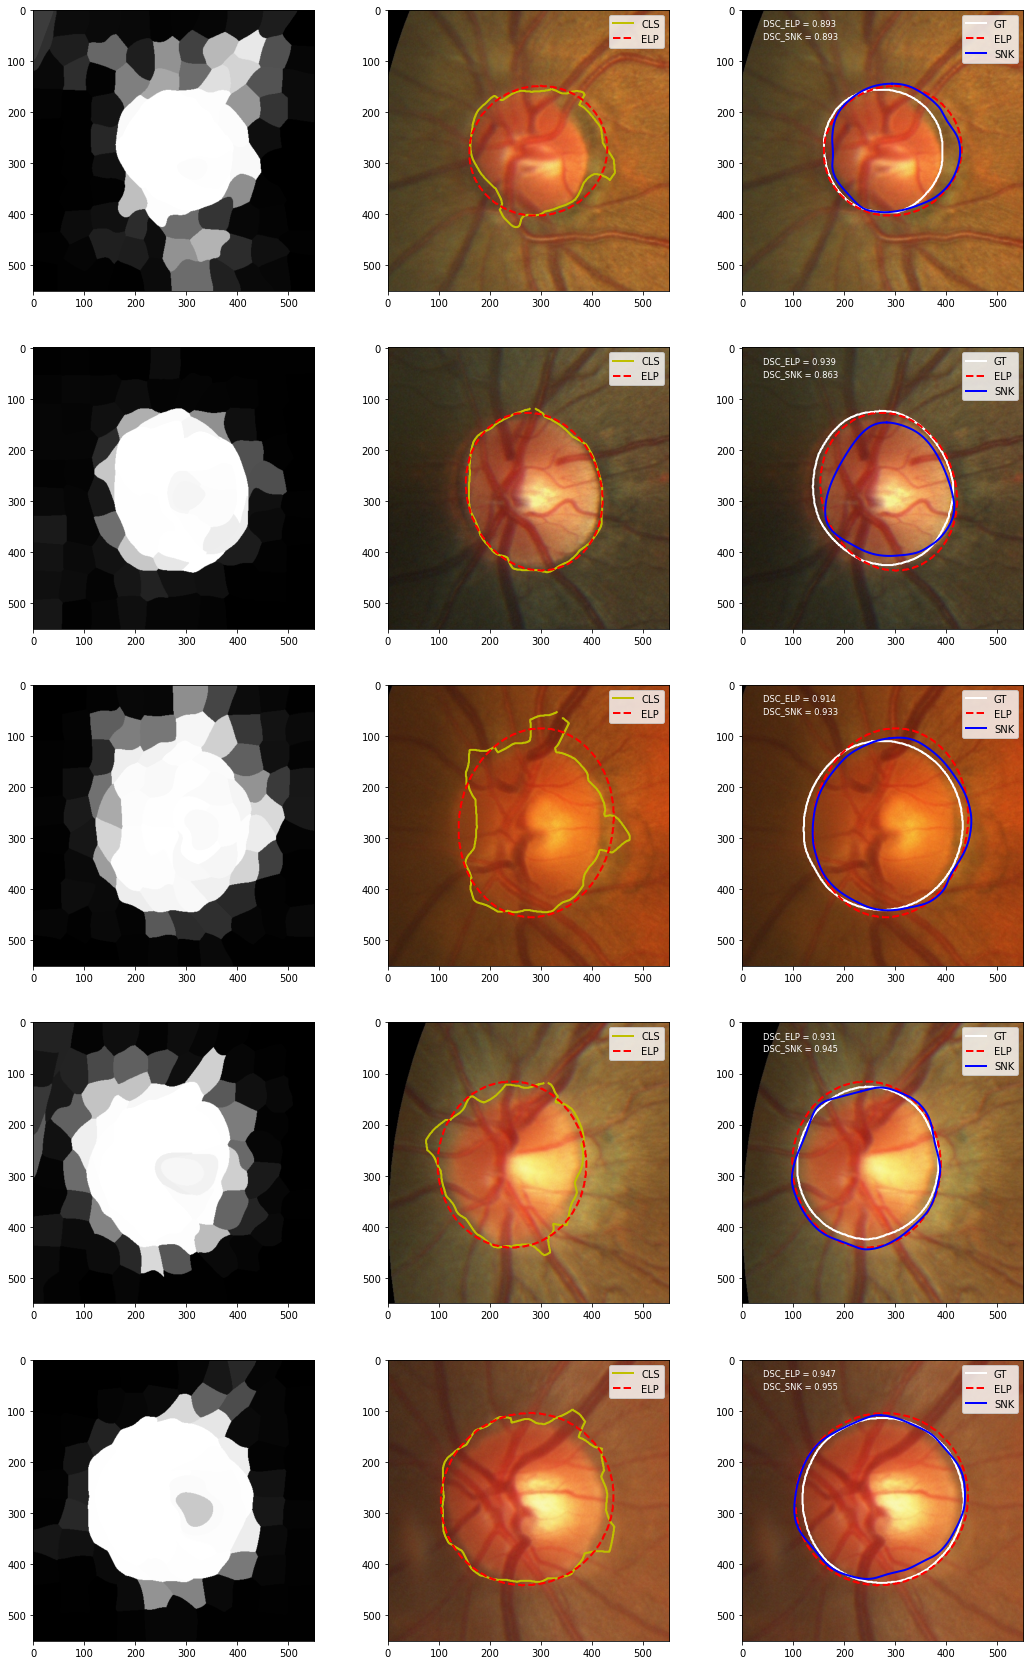

In [87]:
index = list(range(0,450))
random.Random(4).shuffle(index)
idx = index[:5]
i = 0
plt.rcParams["figure.figsize"] = (18,30)
for n in idx:
  image = cv2.imread(df['path'][n],1)
  ROI, _ = ekstrakROI(df['disc_center'][n], 550, image)
  ROI = cv2.cvtColor(ROI, cv2.COLOR_BGR2RGB)
  OD_GT = cv2.imread(df['path_OD_png'][n], 0)
  OD_GT, _ =  ekstrakROI(df['disc_center'][n], 550, OD_GT)
  OD,  ellipse, cnts, snake = segmentasi_superpiksel(ROI, model_svm_proba, pca, scaler)
  gt_cnts, _ = cv2.findContours(OD_GT, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
  gt_cnts = np.array(gt_cnts[0]).squeeze()
  
  # calculate DSC
  snake_contour = [np.expand_dims(snake, axis = 0).astype('int32')]
  ellipse_contour = [np.expand_dims(ellipse, axis = 0)]

  ellipses = np.zeros((ROI.shape[0], ROI.shape[1]), np.uint8)
  snakes = np.zeros((ROI.shape[0], ROI.shape[1]), np.uint8)
  cv2.drawContours(ellipses, ellipse_contour, -1, 255, cv2.FILLED)
  cv2.drawContours(snakes, snake_contour, -1, 255, cv2.FILLED)
  DSC_ELP = np.sum(ellipses[OD_GT==255])*2.0 / (np.sum(OD_GT) + np.sum(ellipses))
  DSC_SNK = np.sum(snakes[OD_GT==255])*2.0 / (np.sum(OD_GT) + np.sum(snakes))

  plt.subplot(5, 3, (i*3)+1), plt.imshow(OD, cmap = 'gray')
  #plt.subplot(5, 5, (i*5)+2), plt.imshow(OD_blur, cmap = 'gray')
  #plt.subplot(5, 5, (i*5)+3), plt.imshow(OD_bin, cmap = 'gray')
  plt.subplot(5, 3, (i*3)+2), 
  plt.imshow(ROI)
  #plt.plot(gt_cnts[:, 0], gt_cnts[:, 1], 'w', lw=2, label='GT')
  plt.plot(cnts[:, 0], cnts[:, 1], 'y', lw=2, label='CLS')
  plt.plot(ellipse[:, 0], ellipse[:, 1], 'r--', lw=2, label='ELP')
  # plt.plot(snake[:, 0], snake[:, 1], 'b', lw=2, label='SNK')
  plt.legend()
  plt.subplot(5, 3, (i*3)+3), 
  plt.imshow(ROI)
  plt.plot(gt_cnts[:, 0], gt_cnts[:, 1], 'w', lw=2, label='GT')
  plt.plot(ellipse[:, 0], ellipse[:, 1], 'r--', lw=2, label='ELP')
  plt.plot(snake[:, 0], snake[:, 1], 'b', lw=2, label='SNK')
  plt.legend()
  plt.text(40, 30, 'DSC_ELP = {}'.format(round(DSC_ELP,3)), fontsize='small', color ='w')
  plt.text(40, 55, 'DSC_SNK = {}'.format(round(DSC_SNK,3)), fontsize='small', color='w')

  i+= 1

plt.show()

# Aquiring data: Ekstraksi fitur superpixel





In [97]:
#Ekstraksi fitur Superpixel
CSS_vectors = []
CSS_maps = []
HIST = []
tags = []
combined_features = []

index_refuge = list(range(50, 450))
index_drishti = list(range(0, 50))
random.shuffle(index_refuge)
random.shuffle(index_drishti)
idx_refuge = index_refuge[:120]
idx_drishti = index_drishti[:20]

idx = np.concatenate((idx_refuge, idx_drishti))
for i in tqdm(range(0, 10), desc = 'Ekstraksi fitur Superpiksel: '):
  image = cv2.imread(df['path'][i], 1)
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  ROI, _ = ekstrakROI(df['disc_center'][i], 550, image)
  gt_OD, _ = ekstrakROI(df['disc_center'][i], 550, cv2.imread(df['path_OD_png'][i], 0))
  numSegments = 100
  segments = slic(ROI, n_segments = numSegments, sigma = 1)
  labels = np.unique(segments)
  map = differenceMap(ROI)

  # ekstrak citra kanal r, g, b, h dan v sekaligus menerapkan CLAHE untuk kanal rgb
  clahe = cv2.createCLAHE(clipLimit =2.0, tileGridSize=(8,8))
  r = clahe.apply(ROI[:,:,0])
  b = clahe.apply(ROI[:,:,1])
  g = clahe.apply(ROI[:,:,2])
  ROI = cv2.cvtColor(ROI, cv2.COLOR_RGB2HSV)
  h = ROI[:,:,0]
  s = ROI[:,:,1]
  images = [r, g, b, h, s]
  for label in labels:
    sp_extract_feature4train(images, label, segments, map, gt_OD)
    

In [99]:
sp_df = pd.DataFrame({'HIST':pd.Series(HIST), 'CSS_map': pd.Series(CSS_maps), 'CSS_vec': pd.Series(CSS_vectors),
                               'combined_feature': pd.Series(combined_features), 'tag':pd.Series(tags)})

In [57]:
sp_df.to_json('/content/gdrive/My Drive/Drive Tugas Akhir/Kode/superpiksel.json')

In [35]:
sp_df = pd.read_json('/content/gdrive/My Drive/Drive Tugas Akhir/Kode/superpiksel.json')

,HIST,CSS_map,CSS_vec,combined_feature,tag
0,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[65, 9], [86, 13], [97, 10], [152, 20], [158,...","[[[65, 9], [86, 13], [97, 10], [152, 20], [158...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",-1
1,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[37, 7], [29, 20], [33, 20], [13, 32], [10, 2...","[[[37, 7], [29, 20], [33, 20], [13, 32], [10, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",-1
2,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[41, 6], [23, 14], [18, 12], [20, 62], [16, 6...","[[[41, 6], [23, 14], [18, 12], [20, 62], [16, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",-1



# Exploratory Data Analysis for SP

In [104]:
OD_df = sp_df[sp_df['tag']==1]
nonOD_df = sp_df[sp_df['tag']==-1]
OD_df.reset_index(inplace=True)
nonOD_df.reset_index(inplace=True)


In [115]:
print(len(nonOD_df['tag']))
print(len(OD_df['tag']))

521
455


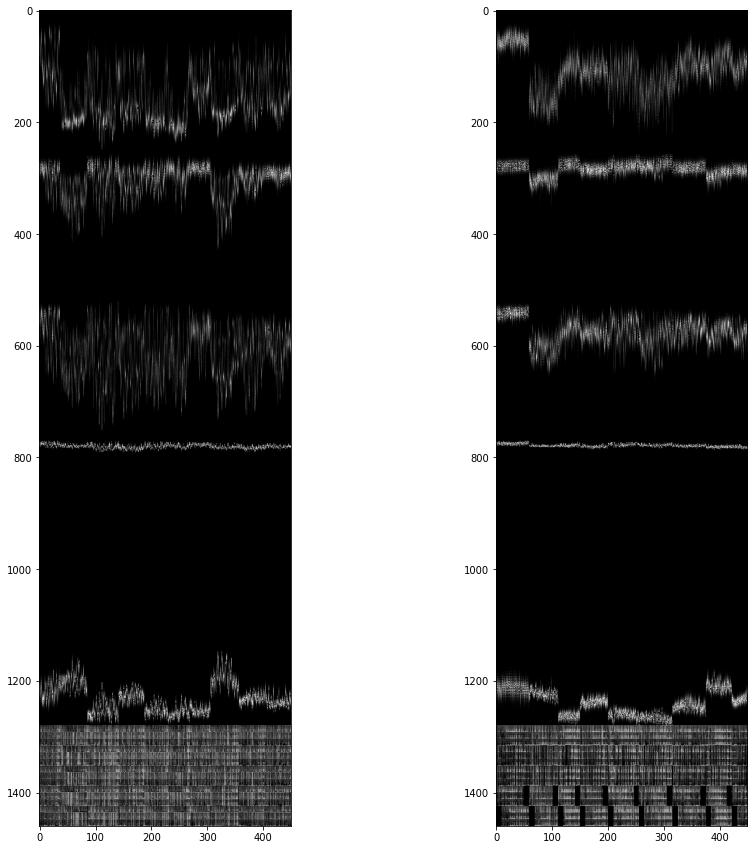

In [116]:
plt.rcParams["figure.figsize"] = (15,15)
feature_map_OD = []
feature_map_nonOD = []
for i in range(450):
  feature_map_OD.append(np.concatenate((OD_df['HIST'][i].flatten(), OD_df['CSS_vec'][i].flatten())))
  feature_map_nonOD.append(np.concatenate((nonOD_df['HIST'][i].flatten(), nonOD_df['CSS_vec'][i].flatten())))
feature_map_OD = np.array(feature_map_OD).T
feature_map_nonOD = np.array(feature_map_nonOD).T
plt.subplot(121), plt.imshow(feature_map_OD, cmap='gray')
plt.subplot(122),plt.imshow(feature_map_nonOD, cmap='gray')
plt.show()

In [ ]:
from scipy.stats import kurtosis 
from scipy.stats import skew

sp_df_temp = sp_df.copy()
for i in range(len(sp_df['HIST'])):
  for j in range(len(sp_df['HIST'][i]):
    sp_df_temp['HIST'][i][j] = sp_df_temp['HIST'][i][j]

# Training model with PCA

In [61]:
# Separating out the features
X = sp_df['combined_feature'].tolist()
# Separating out the target
y = sp_df['tag'].tolist()


In [62]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y,test_size=0.2, stratify=y)


In [73]:
from sklearn.preprocessing import StandardScaler
# Standardizing the features
scaler = StandardScaler()

# fit scaler to trainin data only
scaler.fit(X_train)

# scalling training and testing data (mean = 0, std = 1)
X_training = scaler.transform(X_train)
X_testing = scaler.transform(X_test)

# fit pca model to training data
var = 0.94 # desired retaining variance 
pca = PCA(var) 
pca.fit(X_training)
X_training = pca.transform(X_training)
X_testing = pca.transform(X_testing)

# model training using data with principal component
model_svm_proba = svm.SVC(kernel='rbf', probability=True)
model_svm_proba.fit(X_training, y_train)

# tells how good our model is

predictions_train = model_svm_proba.predict(X_training)
start = time.time()
predictions_test = model_svm_proba.predict(X_testing)
end = time.time()
scores = model_svm_proba.decision_function(X_testing)


# print('AUC : {}'.format(round(roc_auc_score(y_test, scores), 3)))
print('Accuracy train : {} %'.format(round(accuracy_score(predictions_train, y_train), 3)*100))
print('Accuracy dev : {} %'.format(round(accuracy_score(predictions_test, y_test), 3)*100))
print('Error train : {} %'.format(round(1 - accuracy_score(predictions_train, y_train), 3)*100))
print('Error dev : {} %'.format(round(1 - accuracy_score(predictions_test, y_test), 3)*100))
print('testing time : {} s'.format(round((end-start)/len(X_testing[0]), 3)))
print('number of component :{}'.format(X_training.shape[1]))

# print('precision : {}'.format(round(precision_score(predictions, y_test), 3)))
# print('recall : {}'.format(round(recall_score(predictions, y_test), 3)))
# print('F1 : {}'.format(round(f1_score(predictions, y_test), 3)))

Accuracy train : 93.5 %
Accuracy dev : 91.5 %
Error train : 6.5 %
Error dev : 8.5 %
testing time : 0.014 s
number of component :290


In [74]:
# Save pca and scaler model
filename_pca = '/content/gdrive/My Drive/Drive Tugas Akhir/Kode/pca.pkl'
filename_scaler = '/content/gdrive/My Drive/Drive Tugas Akhir/Kode/scaler.pkl'

pickle.dump(pca, open(filename_pca,"wb"))
pickle.dump(scaler, open(filename_scaler,"wb"))

In [ ]:
# Open pca and scaler model
filename_pca = '/content/gdrive/My Drive/Drive Tugas Akhir/Kode/pca.pkl'
filename_scaler = '/content/gdrive/My Drive/Drive Tugas Akhir/Kode/scaler.pkl'
pca = pickle.load(open(filename_pca,'rb'))
scaler = pickle.load(open(filename_scaler, 'rb'))

In [76]:
filename = '/content/gdrive/My Drive/Drive Tugas Akhir/Kode/superpixel_model_svm_proba.sav'
pickle.dump(model_svm_proba, open(filename, 'wb'))

In [ ]:
filename = '/content/gdrive/My Drive/Drive Tugas Akhir/Kode/superpixel_model_svm_proba.sav'
model_svm_proba = pickle.load(open(filename, 'rb'))

In [ ]:

retaining = [1.0, .99, .98, .97, .96, .95, .94, .93, .92, .91, .9]
times = []
num_features = []
acc = []
precision = []
recall = []
f1 = []
auc = []
for i in tqdm(range(len(retaining)), desc = 'progress '):
  var = retaining[i]
  if i == 0:
    X_training = X_train.copy()
    X_testing = X_test.copy()
  else:
    pca_tr = PCA(var) #retaining
    pca_tr.fit(X_train)
    X_training = pca_tr.transform(X_train)
    X_testing = pca_tr.transform(X_test)


  model_svm_proba = svm.SVC(kernel='rbf', probability=True, verbose=True)
  model_svm_proba.fit(X_training, y_train)
  start = time.time()
  predictions = model_svm_proba.predict(X_testing)
  end = time.time()
  scores = model_svm_proba.decision_function(X_testing)
  
  auc.append(round(roc_auc_score(y_test, scores), 3))
  times.append(round(end-start, 3))
  num_features.append(X_training.shape[1])
  acc.append(round(accuracy_score(predictions, y_test), 3))
  precision.append(round(precision_score(predictions, y_test), 3))
  recall.append(round(recall_score(predictions, y_test), 3))
  f1.append(round(f1_score(predictions, y_test), 3))
  


[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]


In [ ]:
result = pd.DataFrame({'variance':retaining,  'num_features':num_features, 'time':times, 'Accuracy': acc, 'Precision': precision, 'recall':recall, 'F1':f1, 'AUC':auc})
result

,variance,num_features,time,Accuracy,Precision,recall,F1,AUC
0,1.00,1460,19.728,0.922,0.845,0.938,0.889,0.976
1,0.99,745,10.060,0.923,0.847,0.939,0.891,0.976
2,0.98,583,7.846,0.922,0.846,0.936,0.889,0.977
3,0.97,481,6.471,0.924,0.850,0.938,0.892,0.976
4,0.96,406,5.493,0.924,0.848,0.939,0.891,0.976
5,0.95,346,4.543,0.924,0.850,0.937,0.892,0.976
6,0.94,298,3.859,0.924,0.847,0.942,0.892,0.976
7,0.93,259,3.322,0.923,0.847,0.939,0.891,0.976
8,0.92,227,2.879,0.923,0.846,0.938,0.890,0.976
9,0.91,201,2.488,0.924,0.846,0.943,0.892,0.976


In [ ]:
X_train = pca_tr.transform(X_train)
X_test = pca_tr.transform(X_test)

In [ ]:
# train model with transform data
from sklearn import svm
model_svm_proba = svm.SVC(kernel='rbf', probability=True, verbose=True)
model_svm_proba.fit(X_train, y_train)

[LibSVM]

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=True)

In [ ]:
OD_df = superpiksel_df[superpiksel_df['tag']==True]
nonOD_df = superpiksel_df[superpiksel_df['tag']==False]
OD_df.reset_index(inplace=True)
nonOD_df.reset_index(inplace=True)
print('OD_data\n')
print(OD_df)
print('\nNon_OD_data\n')
print(nonOD_df)

"\nax1.plot(hist_non[0], '-r', label='red')\nax1.plot(hist_non[1], '-g', label='green')\nax1.plot(hist_non[2], '-b', label='blue')\nax1.plot(hist_non[3], '-c', label='hue')\nax1.plot(hist_non[4], '-m', label='saturation')\nax1.title.set_text('Non-Optic Disc')\nax1.legend()\n\nplt.show()\n"

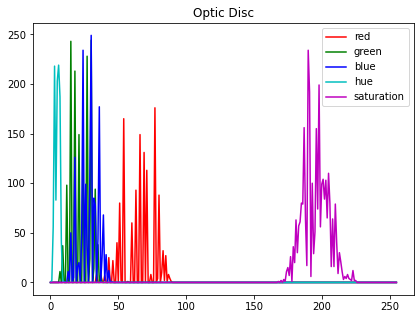

In [96]:
n = random.randint(0, 2)
plt.rcParams["figure.figsize"] = (15,5)
hist = sp_df['HIST'][n]
# hist_non = nonOD_df['HIST'][n]
ax = plt.subplot(121)
#ax1 = plt.subplot(122)
ax.plot(hist[0], '-r', label='red')
ax.plot(hist[1], '-g', label='green')
ax.plot(hist[2], '-b', label='blue')
ax.plot(hist[3], '-c', label='hue')
ax.plot(hist[4], '-m', label='saturation')
ax.title.set_text('Optic Disc')
ax.legend()
"""
ax1.plot(hist_non[0], '-r', label='red')
ax1.plot(hist_non[1], '-g', label='green')
ax1.plot(hist_non[2], '-b', label='blue')
ax1.plot(hist_non[3], '-c', label='hue')
ax1.plot(hist_non[4], '-m', label='saturation')
ax1.title.set_text('Non-Optic Disc')
ax1.legend()

plt.show()
"""

Proyeksi data fitur superpiksel

In [ ]:
import io

out_v = io.open('vecs_sp.tsv', 'w', encoding='utf-8')
out_m = io.open('meta_sp.tsv', 'w', encoding='utf-8')
for i in range(len(superpiksel_df['combined_feature'])):
  if superpiksel_df['tag'][i] == True:
    label = 'OD'
  elif superpiksel_df['tag'][i] == False:
    label = 'non-OD'
  feature = superpiksel_df['combined_feature'][i]
  out_m.write(label + "\n")
  out_v.write('\t'.join([str(x) for x in feature]) + "\n")
out_v.close()
out_m.close()

In [ ]:
try:
  from google.colab import files
except ImportError:
  pass
else:
  files.download('vecs_sp.tsv')
  files.download('meta_sp.tsv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
superpiksel_df_test.head()

,r_mu,r_std,g_mu,g_std,b_mu,b_std,h_mu,h_std,s_mu,s_std,CSS_mu1,CSS_mu2,CSS_mu3,CSS_mu4,CSS_mu5,CSS_std1,CSS_std2,CSS_std3,CSS_std4,CSS_std5,tag
0,4.949219,22.997991,5.949219,32.244085,5.949219,28.230520,3.949219,26.471118,10.949219,32.949674,49.5,62.0,0.0,62.0,0.0,47.0,72.5,0.0,55.0,0.0,False
1,5.750000,28.834658,7.750000,30.981345,11.750000,40.908243,2.750000,19.782213,10.750000,31.901582,62.0,47.5,49.5,62.0,0.0,72.5,48.5,47.0,71.0,0.0,False
2,11.167969,31.677931,7.167969,30.430876,8.167969,32.850025,2.167969,16.253819,11.167969,34.034092,47.5,52.0,62.0,56.0,0.0,48.5,51.5,72.5,45.5,0.0,False
3,11.957031,35.118134,4.957031,24.076094,7.957031,29.294606,2.957031,21.494415,11.957031,35.517960,52.0,47.5,47.5,49.5,0.0,51.5,55.5,48.5,67.0,0.0,False
4,13.789062,31.424053,5.789062,26.046879,8.789062,33.913874,2.789062,19.338131,13.789062,34.156842,47.5,80.5,52.0,48.0,0.0,55.5,99.0,51.5,56.0,0.0,False


In [ ]:
Y = superpiksel_df_test.columns[10:20].tolist()
Yt = superpiksel_df_test.columns[10:21].tolist()
print(Y)

['CSS_mu1', 'CSS_mu2', 'CSS_mu3', 'CSS_mu4', 'CSS_mu5', 'CSS_std1', 'CSS_std2', 'CSS_std3', 'CSS_std4', 'CSS_std5']


In [ ]:
import seaborn as sns
sns.set_theme(style="whitegrid")

fig, axes = plt.subplots(5, 2, figsize=(15, 25), sharey=False)
Y = superpiksel_df_test.columns[10:20].tolist()
for i in range(5):
  for j in range(2):
    sns.boxplot(ax=axes[i, j], y=Y[i+j], x='tag',
                 data=superpiksel_df_test, palette="Set3", width=0.5, dodge=False
                 )
fig.show()


# Training and test model

In [ ]:
import pickle
# save the model to disk
filename = '/content/gdrive/My Drive/Drive Tugas Akhir/Kode/superpixel_model_svm_proba_pca.sav'
pickle.dump(model_svm_proba, open(filename, 'wb'))

In [ ]:
predictions = model_svm_proba.predict(X_test)
print(predictions[0])

-1


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

print('Accuracy: ', round(accuracy_score(predictions, y_test), 3))
print('Precision: ', round(precision_score(predictions, y_test), 3))
print('Recall: ', round(recall_score(predictions, y_test), 3))
print('F1: ', round(f1_score(predictions, y_test), 3))

Accuracy:  0.918
Precision:  0.837
Recall:  0.933
F1:  0.882


In [ ]:
from sklearn.metrics import confusion_matrix

tn, fp, fn, tp = confusion_matrix(y_test, predictions).ravel()

print(f'True Positive: {tp}\nTrue Negative: {tn}\nFalse Positive: {fp}\nFalse Negative: {fn}')

True Positive: 752
True Negative: 1505
False Positive: 62
False Negative: 163


In [ ]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

scores = model_svm_proba.decision_function(X_test)

fpr, tpr, _ = roc_curve(y_test, scores, pos_label=True)
auc = roc_auc_score(y_test, scores)

In [ ]:
print('Area Under Curve = {}'.format(round(auc, 2)))
plt.rcParams["figure.figsize"] = (7,5)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.plot(fpr, tpr)
plt.show()

Model CNN

In [ ]:
superpiksel_df['combined_feature'][0].shape

(1460,)

In [51]:
import tensorflow as tf
model_nn = tf.keras.Sequential([
    tf.keras.Input(shape=(1460,)),
    #tf.keras.layers.Conv1D(64, 5, activation='relu'),
    #tf.keras.layers.MaxPooling1D(pool_size=4),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model_nn.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model_nn.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             (None, 64)                93504     
_________________________________________________________________
dense_11 (Dense)             (None, 64)                4160      
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_12 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_13 (Dense)             (None, 6)                 198       
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 7         
Total params: 99,949
Trainable params: 99,949
Non-trainable params: 0
__________________________________________________

In [52]:
num_epochs = 20
X_train_nn = np.array(X_train)
y_train_nn = np.array(y_train)
X_test_nn = np.array(X_test)
y_test_nn = np.array(y_test)
history = model_nn.fit(X_train_nn, y_train_nn, epochs=num_epochs, validation_data=(X_test_nn, y_test_nn), verbose=1)


Epoch 1/20
311/311 [==============================] - 2s 4ms/step - loss: -252007.1268 - accuracy: 0.0318 - val_loss: -11198653.0000 - val_accuracy: 0.0342
Epoch 2/20
311/311 [==============================] - 1s 3ms/step - loss: -55155816.9359 - accuracy: 0.0322 - val_loss: -461389504.0000 - val_accuracy: 0.0322
Epoch 3/20
311/311 [==============================] - 1s 3ms/step - loss: -916526903.6923 - accuracy: 0.0254 - val_loss: -3484070656.0000 - val_accuracy: 0.0294
Epoch 4/20
311/311 [==============================] - 1s 3ms/step - loss: -5545802287.5897 - accuracy: 0.0250 - val_loss: -13847232512.0000 - val_accuracy: 0.0298
Epoch 5/20
311/311 [==============================] - 1s 3ms/step - loss: -18070611295.1795 - accuracy: 0.0291 - val_loss: -37943848960.0000 - val_accuracy: 0.0278
Epoch 6/20
311/311 [==============================] - 1s 3ms/step - loss: -46800026230.1538 - accuracy: 0.0248 - val_loss: -85165383680.0000 - val_accuracy: 0.0270
Epoch 7/20
311/311 [=============

<Figure size 504x360 with 0 Axes>

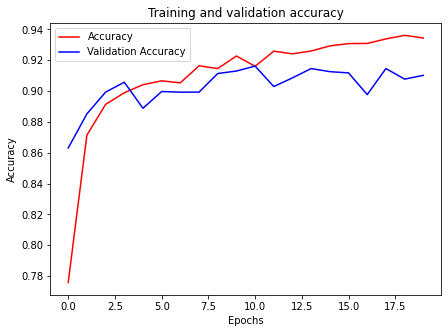

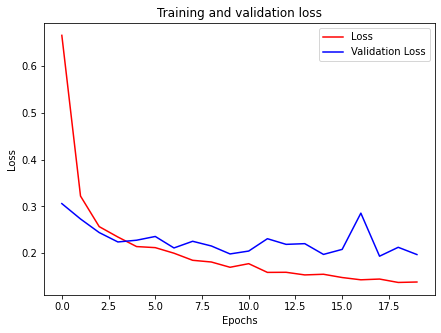

<Figure size 504x360 with 0 Axes>

In [ ]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and validation accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Accuracy", "Validation Accuracy"])

plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.title('Training and validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss", "Validation Loss"])

plt.figure()


# **5. Evaluasi**

**Creation of template histogram**

In [ ]:
# Upload template histogram

file = open('/content/gdrive/My Drive/Drive Tugas Akhir/Kode/template histogram.csv', 'r')

with file:
  read = csv.reader(file)
  hist = list(read)
  histogram_temp = [int(float(x[0])) for x in hist]
  histogram_template = [0] + histogram_temp

file.close()

In [ ]:
tmp = cv2.imread(df['path'][24], 1)
tmp = tmp[:, :, 1]
clahe = cv2.createCLAHE(clipLimit =2.0, tileGridSize=(8,8))
tmp = clahe.apply(tmp)
template_image, _ = ekstrakROI(df['disc_center'][24], 550, tmp)
print(template_image.shape)
print(template_image.dtype)

(551, 551)
uint8


In [ ]:
# inisialisasi list metrik dan parameter
detection = []
percent_detection = []
Fscore_OD = []
Fscore_OC = []
fitur = []
prediksi = []

iterates = len(df)

for i in tqdm(range(0, iterates), desc = 'Number of image that had processed: '):

  # input image dan ground truth
  path = df["path"][i]
  path_OD = df["path_OD_png"][i]
  path_OC = df["path_OC_png"][i]

  src = cv2.imread(path, 1)
  src = cv2.cvtColor(src, cv2.COLOR_BGR2RGB)
  OD_mask_gt = cv2.imread(path_OD, 0) 
  OC_mask_gt = cv2.imread(path_OC, 0)
  
  ### Preprocessing #######################################################
  # ekstraksi kanal hijau citra
  img = src[:,:,1]

  # CLAHE
  clahe = cv2.createCLAHE(clipLimit =2.0, tileGridSize=(8,8))
  cl_img = clahe.apply(img)

  """
  ### Lokalisasi OD ######################################################

  ret,_ = cv2.threshold(cl_img,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
  cons = 8/3

  # modified otsu thresholding
  th = ret*cons
  _, otsu_img = cv2.threshold(cl_img,th,255,cv2.THRESH_BINARY)

  # Distance Map 
  dist_img = cv2.distanceTransform(otsu_img, cv2.DIST_L2, cv2.DIST_MASK_PRECISE)

  # Maximum pixel at distance map
  maxima_img = maxima(dist_img)
  maxima_img = cv2.convertScaleAbs(maxima_img)

  # Ekstrak centroid berpotensi sebagai disc center
  centers = centroids(maxima_img)
  
  # Histogram template matching
  s = 600 # ukuran ROI s * s
  diskCenter = histogram_template_matching(centers, s, cl_img,
                                           histogram_template)

  # Ekstrak ROI
  ROI, koordinat = ekstrakROI(diskCenter, s, cl_img)
  """
  result = cv2.matchTemplate(cl_img, template_image, cv2.TM_CCOEFF_NORMED)
  (minVal, maxVal, minLoc, maxLoc) = cv2.minMaxLoc(result)

  (startX, startY) = maxLoc
  endX = startX + template_image.shape[1]
  endY = startY + template_image.shape[0]
  disk_center = (round((endX+startX)/2), round((endY+startY)/2))

  # draw the bounding box on the image
  ROI, koordinat = ekstrakROI(disk_center, 550, cl_img)

  ### Segmentasi OD dan OC ##############################################
  OD_mask, OC_mask = segmentasi_OC_OD_kmeans(ROI)

  ### Ekstraksi Fitur ###################################################
  


  ### Klasifikasi Glaukoma ##############################################



  ### Perhitungan Metrik ################################################

  # resize mask dan boundary
  ODmask = resizeMask(koordinat, cl_img.shape, OD_mask)
  OCmask = resizeMask(koordinat, cl_img.shape, OC_mask)

  # Mengecek hasil lokalisasi
  deteksi, percentage = checkROI(OD_mask_gt, disk_center)
  detection.append(deteksi)
  percent_detection.append(percentage)
  # Mengecek hasil segmentasi OD dan OC
  Fscore_OD.append(np.sum(ODmask[OD_mask_gt==255])*2.0 / (np.sum(ODmask) + np.sum(OD_mask_gt)))
  Fscore_OC.append(np.sum(OCmask[OC_mask_gt==255])*2.0 / (np.sum(OCmask) + np.sum(OC_mask_gt)))



berhenti di 224

In [ ]:
result = pd.DataFrame({"detection_rate":detection,"percent_detection" : percent_detection,  "Fscore_OD" : Fscore_OD , "Fscore_OC" : Fscore_OC })
#result.to_json('/content/gdrive/My Drive/Drive Tugas Akhir/Kode/result.json')

In [ ]:
result = pd.read_json('/content/gdrive/My Drive/Drive Tugas Akhir/Kode/result.json')
result.head()

,detection_rate,percent_detection,Fscore_OD,Fscore_OC
0,0,0.000000,0.000000,0.000000
1,1,100.000000,0.576139,0.899253
2,1,96.606051,0.000000,0.000000
3,1,100.000000,0.000000,0.000000
4,0,0.000000,0.000000,0.000000


In [ ]:
result['detection_rate'] = result['detection_rate'] + 1 - 1
result.sample(n=10)
result.to_json('/content/gdrive/My Drive/Drive Tugas Akhir/Kode/result.json')

,detection_rate,percent_detection,Fscore_OD,Fscore_OC
422,1,100.0,0.000000,0.000000
449,1,100.0,0.827263,0.000000
83,1,100.0,0.895886,0.682602
179,1,100.0,0.542150,0.429184
17,1,100.0,0.000000,0.646321
314,1,100.0,0.000000,0.723115
338,1,100.0,0.848434,0.000000
352,1,100.0,0.631350,0.578274
15,1,100.0,0.623724,0.000000
134,1,100.0,0.473330,0.000000


In [ ]:
indeks = result.index[result['detection_rate'] == 0].tolist()
print(indeks)

[6, 38, 40, 47, 96, 169, 195, 226, 261, 263, 308, 356, 385, 387, 404, 411, 428]


In [ ]:
round(result.describe().iloc[[1, 2, 3, 7]], 2)

AttributeError: ignored

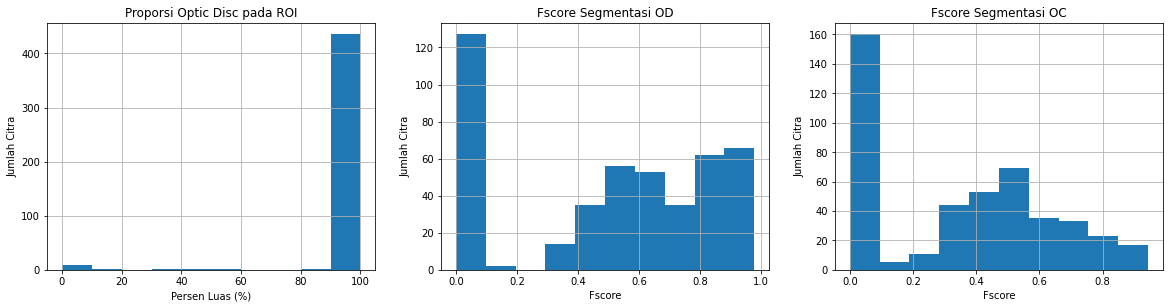

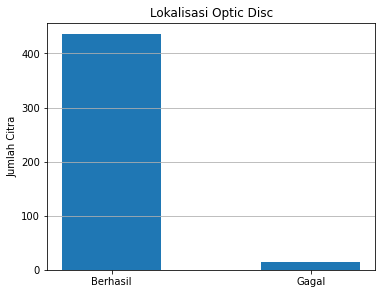

In [ ]:


plt.rcParams["figure.figsize"] = (20,10)
plt.subplot(2,3,1), plt.hist(result['percent_detection'], bins = 10)
plt.grid()
plt.ylabel('Jumlah Citra')
plt.xlabel('Persen Luas (%)')
plt.title('Proporsi Optic Disc pada ROI')

plt.subplot(2,3,2), plt.hist(result['Fscore_OD'], bins = 10)
plt.grid()
plt.ylabel('Jumlah Citra')
plt.xlabel('Fscore')
plt.title('Fscore Segmentasi OD')

plt.subplot(2,3,3), plt.hist(result['Fscore_OC'], bins = 10)
plt.grid()
plt.ylabel('Jumlah Citra')
plt.xlabel('Fscore')
plt.title('Fscore Segmentasi OC')
plt.show()

count_true = sum(result['detection_rate'] == 1)
count_false = sum(result['detection_rate'] == 0)
label = ('Berhasil', 'Gagal')
lokalisasi = (count_true, count_false)
x_coords = np.arange(2)

plt.subplot(2,3,4), plt.bar(x_coords, lokalisasi,  tick_label = label, width = 0.5)
plt.grid(axis ='y')
plt.ylabel('Jumlah Citra')
plt.title('Lokalisasi Optic Disc')
plt.show()

In [ ]:
count = sum(result['percent_detection'] < 90)
print(count)

15


In [ ]:
print(indeks[5])

24


In [ ]:

plt.rcParams["figure.figsize"] = (15,15)
@interact(n = (0, len(indeks)-1))
def deteksi(n=0):
# for i in indeks[n]:
  # n = random.randint(1, 150)
  i = indeks[n]
  #image = df['path_OD_png'][i]
  src = cv2.imread(df['path'][i], 1)
  src = cv2.cvtColor(src, cv2.COLOR_BGR2RGB)
  #src = cv2.imread(image, 1)
  #src = cv2.cvtColor(src, cv2.COLOR_BGR2RGB)
    
  ### Preprocessing #######################################################
  # ekstraksi kanal hijau citra
  img = src[:,:,1]

  # CLAHE
  clahe = cv2.createCLAHE(clipLimit =2.0, tileGridSize=(8,8))
  cl_img = clahe.apply(img)

  ### Lokalisasi OD ######################################################

  ret,_ = cv2.threshold(cl_img,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
  cons = 7/3

  # modified otsu thresholding
  th = ret*cons
  _, otsu_img = cv2.threshold(cl_img,th,255,cv2.THRESH_BINARY)

  # Distance Map 
  dist_img = cv2.distanceTransform(otsu_img, cv2.DIST_L2, cv2.DIST_MASK_PRECISE)

  # Maximum pixel at distance map
  maxima_img = maxima(dist_img)
  maxima_img = cv2.convertScaleAbs(maxima_img)
  
  # Ekstrak centroid berpotensi sebagai disc center
  centers = centroids(maxima_img)
  bright_img = brightspot(centers, src)
  
  # Histogram template matching
  s = 600 # ukuran ROI s * s
  diskCenter = histogram_template_matching(centers, s, cl_img,
                                            histogram_template)


  ROI, koordinat = ekstrakROI(diskCenter, s, src)
  hist = cv2.calcHist(ROI, [1], None, [256], [0,256])
  hist_temp = np.array(histogram_template)/max(histogram_template)
  hist = np.array(hist)/max(hist)

  diff = hist - hist_temp
  diff = diff**2
  diff = np.sum(diff)
  corr = 1/(1+diff)
  
  plt.subplot(3,3,1),plt.imshow(bright_img)
  plt.title("brightspot")
  plt.subplot(3,3,2),plt.imshow(cl_img, cmap = 'gray')
  plt.title("CLAHE")
  plt.subplot(3,3,3),plt.imshow(otsu_img, cmap = 'gray')
  plt.title("Otsu thresholding")
  plt.subplot(3,3,4),plt.imshow(dist_img, cmap = 'gray')
  plt.title("distance image")
  plt.subplot(3,3,5),plt.imshow(maxima_img, cmap = 'gray')
  plt.title("maxima")
  plt.subplot(3,3,6),plt.imshow(ROI)
  plt.title("ROI")
  plt.subplot(3,3,7),plt.plot(hist_temp)
  plt.title("histogram template")
  plt.subplot(3,3,8),plt.plot(hist)
  plt.title("Histogram ROI")

  plt.tight_layout()
  plt.show()
  print("correlation : {:.8f}".format(corr))



In [ ]:
from skimage.segmentation import slic, felzenszwalb
from skimage.segmentation import mark_boundaries
from matplotlib import pyplot as plt
from ipywidgets import interact
import cv2
import random 

plt.rcParams["figure.figsize"] = (20,8)
index = []
for i in range(len(indeks)):
  
  n = random.randint(1, 150)

  #image = df['path_OD_png'][i]
  src = cv2.imread(df['path'][i], 1)
  src = cv2.cvtColor(src, cv2.COLOR_BGR2RGB)
  #src = cv2.imread(image, 1)
  #src = cv2.cvtColor(src, cv2.COLOR_BGR2RGB)
    
  ### Preprocessing #######################################################
  # ekstraksi kanal hijau citra
  img = src[:,:,1]

  # CLAHE
  clahe = cv2.createCLAHE(clipLimit =2.0, tileGridSize=(8,8))
  cl_img = clahe.apply(img)

  ### Lokalisasi OD ######################################################

  ret,_ = cv2.threshold(cl_img,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
  cons = 8/3

  # modified otsu thresholding
  th = ret*cons
  _, otsu_img = cv2.threshold(cl_img,th,255,cv2.THRESH_BINARY)
  retval, labels, centers = cv2.kmeans(pixel_vals, k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS) 

  # convert data into 8-bit values 
  centers = np.uint8(centers)
  segmented_data = centers[labels.flatten()] 
  
  # reshape data into the original image dimensions 
  segmented_image = segmented_data.reshape((ROI.shape)) 
  
  # mengambil label dengan nilai value tertinggi pertama dan kedua
  
  centers.sort()
  max_value = max(centers)
  # Distance Map 
  dist_img = cv2.distanceTransform(otsu_img, cv2.DIST_L2, cv2.DIST_MASK_PRECISE)

  # Maximum pixel at distance map
  maxima_img = maxima(dist_img)
  maxima_img = cv2.convertScaleAbs(maxima_img)
  
  # Ekstrak centroid berpotensi sebagai disc center
  centers = centroids(maxima_img)
  if centers == []:
    index.append(i)

  
  # Histogram template matching
  s = 600 # ukuran ROI s * s
  diskCenter = histogram_template_matching(centers, s, cl_img,
                                            histogram_template)

  
  # Ekstrak ROI
  ROI, koordinat = ekstrakROI(diskCenter, s, src)

  numSegments = 100
  segments = slic(ROI, n_segments = numSegments, sigma = 10)
  #segments_fz = felzenszwalb(ROI, scale=100, sigma=5, min_size=50)


  #ROI = cv2.cvtColor(ROI, cv2.COLOR_RGB2GRAY)
  ROI3 = mark_boundaries(ROI, segments)
  #plt.subplot(2,5,i+1), plt.imshow(ROI3)

#plt.show()

# **1. Preprocessing** 
CLAHE dan/ atau homomorphic filtering

In [ ]:
import cv2
import numpy as np
from matplotlib import pyplot as plt 


# Read retinal image, CV2 menginput citra dengan channel BGR
src1 = cv2.imread("/content/gdrive/My Drive/Drive Tugas Akhir/Dataset/tes image/drishtiGS_018.png", 1) # DRISHTI
# src2 = cv2.imread("/content/gdrive/My Drive/Drive Tugas Akhir/Dataset/tes image/image3prime.tif", 1) # RIGA (sementara pakai drishti dulu)
src3 = cv2.imread("/content/gdrive/My Drive/Drive Tugas Akhir/Dataset/tes image/g0005.jpg", 1) # REFUGE (sementara pakai drishti dulu)

# Citra dirubah menjadi RGB karena plt.imshow menampilkan citra dengan susunan 
# channel RGB sedangkan cv2 membaca dengan urutan channel BGR
src1 = cv2.cvtColor(src1, cv2.COLOR_BGR2RGB)
src2 = cv2.cvtColor(src2, cv2.COLOR_BGR2RGB)
src3 = cv2.cvtColor(src3, cv2.COLOR_BGR2RGB)

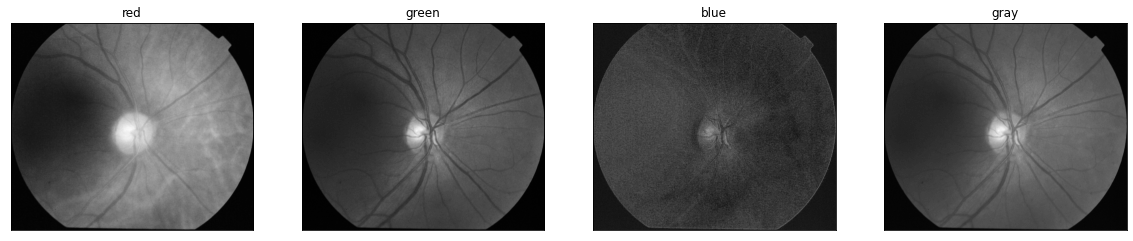

In [ ]:
green = src1[:, :, 1]
red = src1[:, :, 0]
blue = src1[:, :, 2]
gray = cv2.cvtColor(src1, cv2.COLOR_BGR2GRAY)

images = [red, green, blue, gray]
titles = ['red', 'green', 'blue', 'gray']
figure(images, titles, coloumn=4)

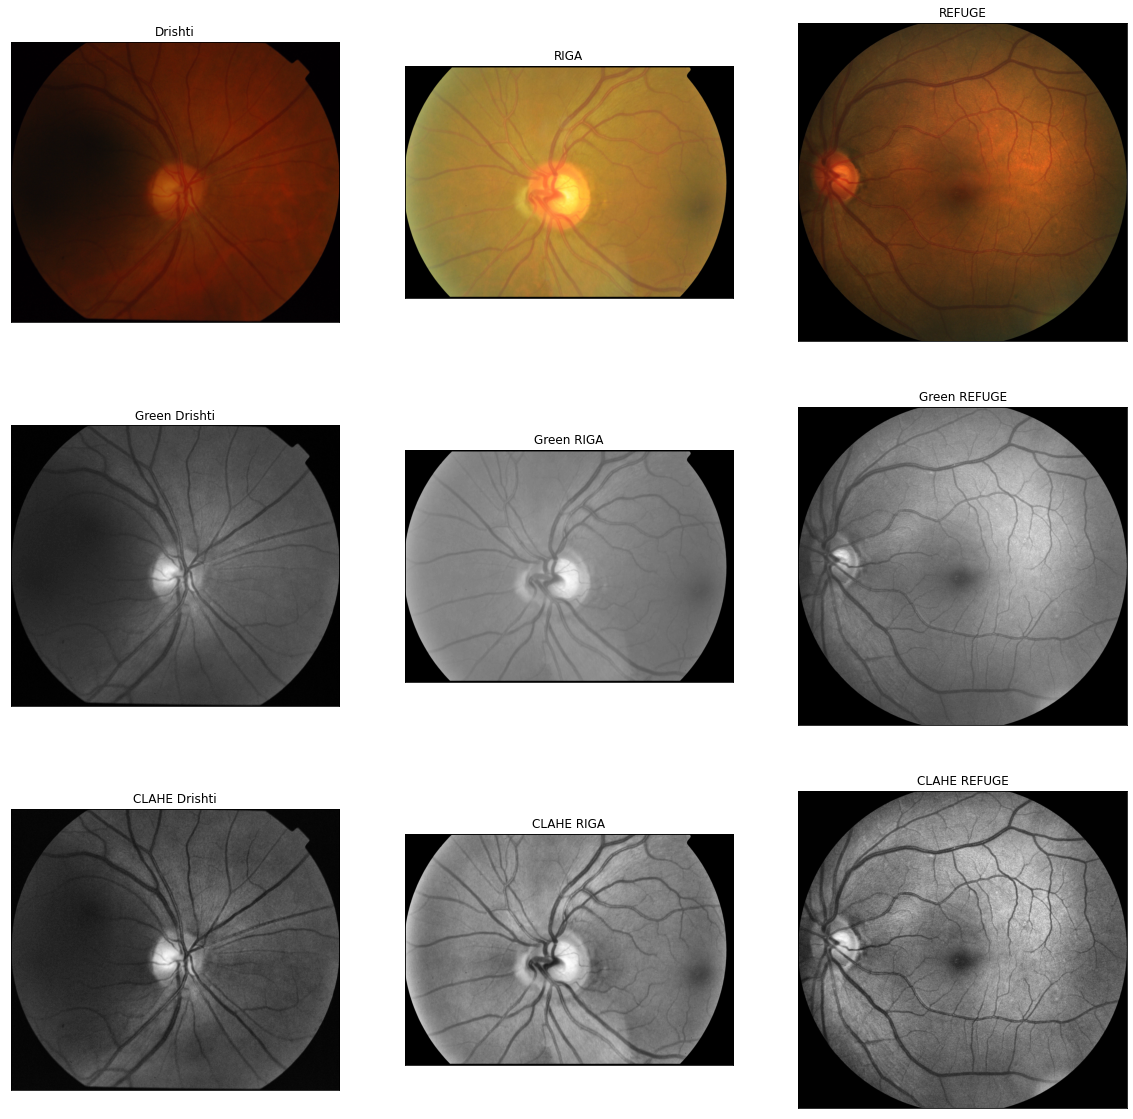

In [ ]:
# Extract green channel of image and convert it to grayscale
img1 = src1[:,:,1]
img2 = src2[:,:,1]
img3 = src3[:,:,1]

# Implementing CLAHE 
clahe = cv2.createCLAHE(clipLimit =2.0, tileGridSize=(8,8))
cl_img1 = clahe.apply(img1)
cl_img2 = clahe.apply(img2)
cl_img3 = clahe.apply(img3)

cl_image = [cl_img1, cl_img2, cl_img3]
gre_image = [img1, img2, img3]
src_image = [src1, src2, src3]

images = src_image + gre_image + cl_image
titles = ['Drishti', 'RIGA', 'REFUGE', 'Green Drishti', 'Green RIGA',
          'Green REFUGE', 'CLAHE Drishti', 'CLAHE RIGA', 'CLAHE REFUGE']

figure(images, titles)

# Input Ground Truth


In [ ]:
"""
# fungsi untuk mengkonversi groundtruth RIGA
def rigaGT(path, shape=None):
  import cv2
  import numpy as np
  from matplotlib import pyplot as plt 

  #coming soon
  mask = cv2.imread(path, 1)
  print(type(mask))
  h, w, _ = mask.shape
  
  idx = np.where(mask == [46, 49, 68])
  idx = list(zip(*idx))
  idx = np.array(idx)

  boundary = np.zeros([h, w], np.uint8)

  boundary[idx[:, 0], idx[:, 1]] = 255

  output = cv2.connectedComponentsWithStats(boundary, cv2.CV_32S)
  (numLabels, labels, stats, centroids) = output

  componentMask = (labels == 100).astype("uint8") * 255

  print((h, w))
  print(labels.shape)
  print(numLabels)
  plt.subplot(131), plt.imshow(boundary, cmap = 'gray')
  plt.subplot(132), plt.imshow(labels, cmap = 'gray')
  plt.subplot(133), plt.imshow(componentMask, cmap = 'gray')
  plt.show()
  

rigaGT("/content/gdrive/My Drive/Drive Tugas Akhir/Dataset/tes image/GT/riga/Image3-1.tif")
"""


In [ ]:
gt_path = "/content/gdrive/My Drive/Drive Tugas Akhir/Dataset/tes image/GT/drishti/"

# Upload data ground truth dari dataset

#Drishti
OD_mask1_gt, OD_bound1_gt = drishtiGT(gt_path + "drishtiGS_018_ODAvgBoundary.txt", src1.shape) 
OC_mask1_gt, OC_bound1_gt  = drishtiGT(gt_path + "drishtiGS_018_CupAvgBoundary.txt", src1.shape)

# RIGA
# OD_mask2_gt, OD_bound2_gt  = drishtiGT(gt_path + "drishtiGS_036_ODAvgBoundary.txt", src2.shape) #rigaGT
# OC_mask2_gt, OC_bound2_gt  = drishtiGT(gt_path + "drishtiGS_036_CupAvgBoundary.txt", src2.shape)

# REFUGE
OD_mask3_gt, OC_mask3_gt, OD_bound3_gt, OC_bound3_gt  = refuGT("/content/gdrive/My Drive/Drive Tugas Akhir/Dataset/tes image/GT/refuge/g0005.bmp") #refuGT




# **2. Lokalisasi OD**
1.   Bright region detection
2.   Template matching




**Bright Region Detection**



1. Otsu Thresholding
2. Eucledian Distance Map
3. Select max point in distance map
4. Extract Centroid






**Otsu Thresholding**

In [ ]:
# Get Otsu Threshold
ret1,_ = cv2.threshold(cl_img1,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
ret2,_ = cv2.threshold(cl_img2,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
ret3,_ = cv2.threshold(cl_img3,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)

cons = 8/3
# modified otsu thresholding
th1 = ret1*cons
th2 = ret2*cons
th3 = ret3*cons

_, otsu_img1 = cv2.threshold(cl_img1,th1,255,cv2.THRESH_BINARY)
_, otsu_img2 = cv2.threshold(cl_img2,th2,255,cv2.THRESH_BINARY)
_, otsu_img3 = cv2.threshold(cl_img3,th3,255,cv2.THRESH_BINARY)

otsu_image = [otsu_img1, otsu_img2, otsu_img3]
otsu_title = ["otsu 1", "otsu 2", "otsu 3"]

for a in range(3):
  plt.subplot(1,3, a+1), plt.imshow(otsu_image[a], cmap = 'gray')
  plt.title(otsu_title[a])
  plt.xticks([]), plt.yticks([])
plt.show()

NameError: ignored

**Eucledian distance map**

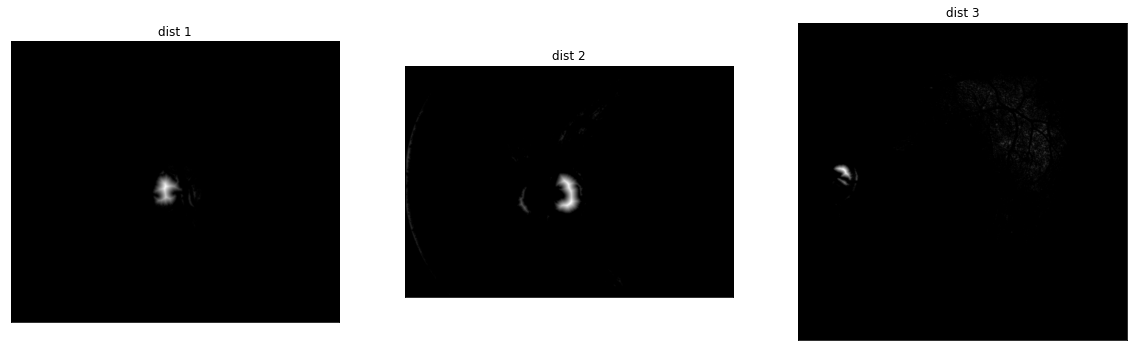

In [ ]:
dist_img1 = cv2.distanceTransform(otsu_img1, cv2.DIST_L2, cv2.DIST_MASK_PRECISE)
dist_img2 = cv2.distanceTransform(otsu_img2, cv2.DIST_L2, cv2.DIST_MASK_PRECISE)
dist_img3 = cv2.distanceTransform(otsu_img3, cv2.DIST_L2, cv2.DIST_MASK_PRECISE)

dist_image = [dist_img1, dist_img2, dist_img3]
dist_title = ["dist 1", "dist 2", "dist 3"]

for a in range(3):
  plt.subplot(1,3, a+1), plt.imshow(dist_image[a], cmap = 'gray')
  plt.title(dist_title[a])
  plt.xticks([]), plt.yticks([])
plt.show()

**Select max point in dist map function**

In [ ]:
maxima1 = maxima(dist_img1)
maxima2 = maxima(dist_img2)
maxima3 = maxima(dist_img3)

maxima_image = [maxima1, maxima2, maxima3]
maxima_title = ["maxima 1", "maxima 2", "maxima 3"]

figure(maxima_image, maxima_title)


Saran pengembangan :
1.  Gunakan seleksi blob

**Extract Cenroid of Bright Region**

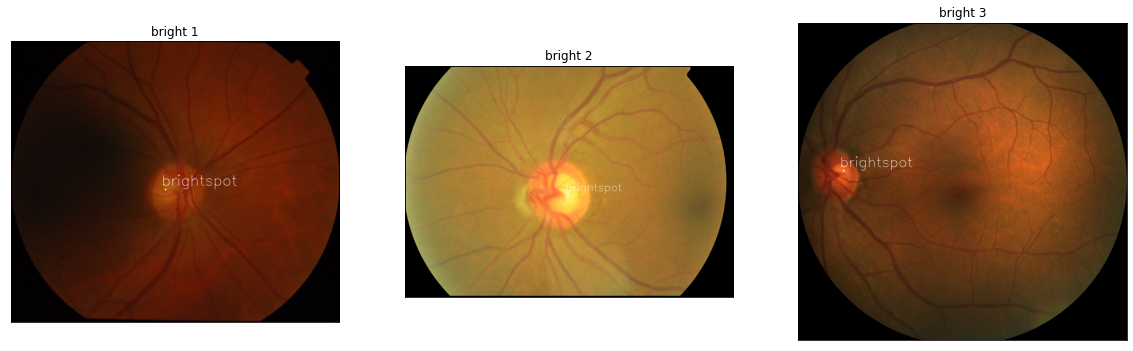

In [ ]:
maxima1 = cv2.convertScaleAbs(maxima1)
maxima2 = cv2.convertScaleAbs(maxima2)
maxima3 = cv2.convertScaleAbs(maxima3)

centroids1 = centroids(maxima1)
centroids2 = centroids(maxima2)
centroids3 = centroids(maxima3)

br_img1 = brightspot(centroids1, src1)
br_img2 = brightspot(centroids2, src2)
br_img3 = brightspot(centroids3, src3)

br_image = [br_img1, br_img2, br_img3]
br_title = ["bright 1", "bright 2", "bright 3"]

figure(br_image, br_title)



Saran pengembangan :
1. Gunakan bright fringe trimming

**Histogram Template Matching**


1.   Creation of template histogram
2.   Template matching



**Histogram Template Matching**

Vessel removal

# **3. Segmentasi OC dan OD**
1. Kmeans + Houghtransform (mvoulana et al)
2. Active disc + Houghtransform (kumar et al)
3. Superpixel classification (Cheng et al)

**Kmeans + Circle Hough Transform**

In [ ]:
OD_mask1, OC_mask1, OD_bound1, OC_bound1 = segmentasi_OC_OD_kmeans(ROI1)
OD_mask2, OC_mask2, OD_bound2, OC_bound2 = segmentasi_OC_OD_kmeans(ROI2)
OD_mask3, OC_mask3, OD_bound3, OC_bound3 = segmentasi_OC_OD_kmeans(ROI3)

**Active Disc + Hough Transform**

In [ ]:
# Coming soon


**Superpixel Segmentation**

In [ ]:
# Coming soon

In [ ]:
s = 600 # dummy

ODmask1 = resizeMask(centroid1, s, cl_img1.shape, OD_mask1)
OCmask1 = resizeMask(centroid1, s, cl_img1.shape, OC_mask1)
ODbound1 = resizeMask(centroid1, s, cl_img1.shape, OD_bound1)
OCbound1 = resizeMask(centroid1, s, cl_img1.shape, OC_bound1)

ODmask2 = resizeMask(centroid2, s, cl_img2.shape, OD_mask2)
OCmask2 = resizeMask(centroid2, s, cl_img2.shape, OC_mask2)
ODbound2 = resizeMask(centroid2, s, cl_img2.shape, OD_bound2)
OCbound2 = resizeMask(centroid2, s, cl_img2.shape, OC_bound2)

ODmask3 = resizeMask(centroid3, s, cl_img3.shape, OD_mask3)
OCmask3 = resizeMask(centroid3, s, cl_img3.shape, OC_mask3)
ODbound3 = resizeMask(centroid3, s, cl_img3.shape, OD_bound3)
OCbound3 = resizeMask(centroid3, s, cl_img3.shape, OC_bound3)

# Menampilkan boundary hasil segmentasi (biru) dan groundtruth (hijau)
segmentasiOD1 = drawMask(ODbound1, src1, tipe = 'biru')
segmentasiOD1 = drawMask(OD_bound1_gt, segmentasiOD1, tipe = 'hijau')

segmentasiOC1 = drawMask(OCbound1, src1, tipe = 'biru')
segmentasiOC1 = drawMask(OC_bound1_gt, segmentasiOC1, tipe = 'hijau')

segmentasiOD2 = drawMask(ODbound2, src2, tipe = 'biru')
# segmentasiOD2 = drawMask(OD_bound2_gt, segmentasiOD2, tipe = 'hijau')

segmentasiOC2 = drawMask(OCbound2, src2, tipe = 'biru')
# segmentasiOC2 = drawMask(OC_bound2_gt, segmentasiOC2, tipe = 'hijau')

segmentasiOD3 = drawMask(ODbound3, src3, tipe = 'biru')
segmentasiOD3 = drawMask(OD_bound3_gt, segmentasiOD3, tipe = 'hijau')

segmentasiOC3 = drawMask(OCbound3, src3, tipe = 'biru')
segmentasiOC3 = drawMask(OC_bound3_gt, segmentasiOC3, tipe = 'hijau')


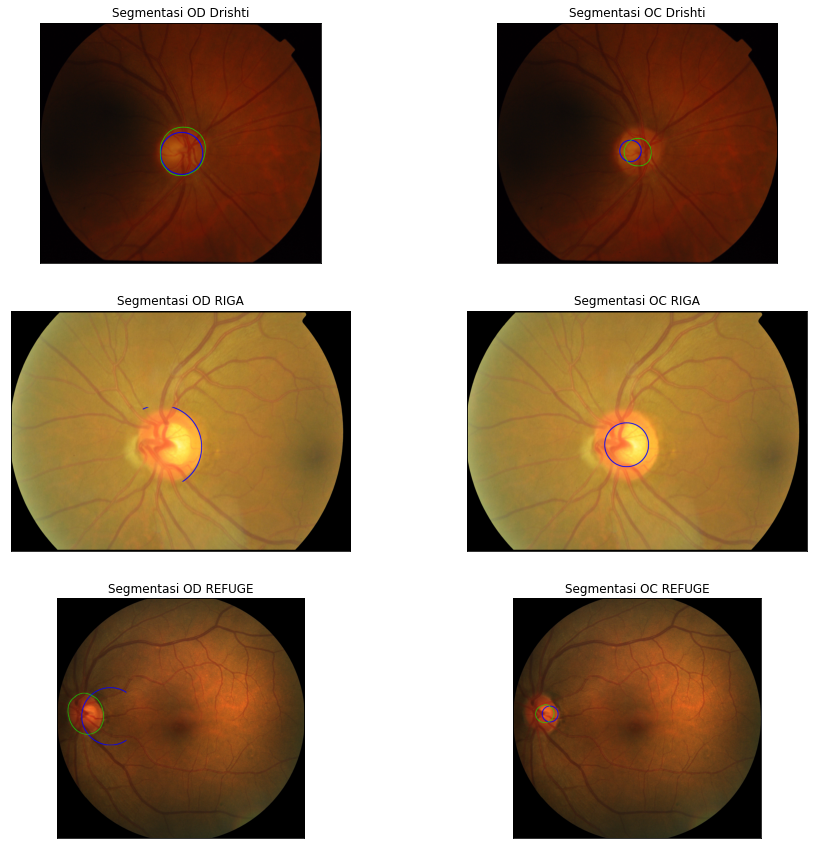

In [ ]:
images = [segmentasiOD1, segmentasiOC1, segmentasiOD2, segmentasiOC2,
          segmentasiOD3, segmentasiOC3]
titles = ['Segmentasi OD Drishti', 'Segmentasi OC Drishti','Segmentasi OD RIGA', 'Segmentasi OC RIGA',
          'Segmentasi OD REFUGE', 'Segmentasi OC REFUGE']

figure(images, titles, 2, 15)



**Metrik**

In [ ]:
lokalisasi1 = hitungPred(OD_mask3_gt, centroid3, tipe = 1)
print("Hasil lokalisasi : ", lokalisasi1)

Hasil lokalisasi :  True


In [ ]:
metrik_1 = [MetricCalc(OD_mask1_gt, ODmask1, tipe = 2), MetricCalc(OC_mask1_gt, OCmask1, tipe = 2)]
# metrik_2 = [MetricCalc(OD_mask2_gt, ODmask2, tipe = 2), MetricCalc(OC_mask2_gt, OCmask2, tipe = 2)]
metrik_3 = [MetricCalc(OD_mask3_gt, ODmask3, tipe = 2), MetricCalc(OC_mask3_gt, OCmask3, tipe = 2)]

print("OD 1:", metrik_1[0][2])
print("OC 1:", metrik_1[1][2])
#print("OD 2:", metrik_2[0][2])
#print("OC 2:", metrik_2[1][2])
print("OD 3:", metrik_3[0][2])
print("OC 3:", metrik_3[1][2])

OD 1: 0.88
OC 1: 0.59
OD 3: 0.38
OC 3: 0.61


In [ ]:
import pandas as pd

df = pd.read_json('/content/gdrive/My Drive/Drive Tugas Akhir/Kode/dataframe.json')
df.groupby(['tag']).size()

tag
Glaucoma     72
Normal      378
dtype: int64

In [ ]:
df.sample(n=10)

,path,file_name,path_OD,path_OC,disc_center,tag,dataset,shape,path_OD_png,path_OC_png
413,/content/gdrive/My Drive/Drive Tugas Akhir/Dat...,n0324.jpg,/content/gdrive/My Drive/Drive Tugas Akhir/Dat...,/content/gdrive/My Drive/Drive Tugas Akhir/Dat...,"[-99, -99]",Normal,refuge,"[2056, 2124, 3]",/content/gdrive/My Drive/Drive Tugas Akhir/Dat...,/content/gdrive/My Drive/Drive Tugas Akhir/Dat...
409,/content/gdrive/My Drive/Drive Tugas Akhir/Dat...,n0320.jpg,/content/gdrive/My Drive/Drive Tugas Akhir/Dat...,/content/gdrive/My Drive/Drive Tugas Akhir/Dat...,"[-99, -99]",Normal,refuge,"[2056, 2124, 3]",/content/gdrive/My Drive/Drive Tugas Akhir/Dat...,/content/gdrive/My Drive/Drive Tugas Akhir/Dat...
116,/content/gdrive/My Drive/Drive Tugas Akhir/Dat...,n0027.jpg,/content/gdrive/My Drive/Drive Tugas Akhir/Dat...,/content/gdrive/My Drive/Drive Tugas Akhir/Dat...,"[-99, -99]",Normal,refuge,"[2056, 2124, 3]",/content/gdrive/My Drive/Drive Tugas Akhir/Dat...,/content/gdrive/My Drive/Drive Tugas Akhir/Dat...
230,/content/gdrive/My Drive/Drive Tugas Akhir/Dat...,n0141.jpg,/content/gdrive/My Drive/Drive Tugas Akhir/Dat...,/content/gdrive/My Drive/Drive Tugas Akhir/Dat...,"[-99, -99]",Normal,refuge,"[2056, 2124, 3]",/content/gdrive/My Drive/Drive Tugas Akhir/Dat...,/content/gdrive/My Drive/Drive Tugas Akhir/Dat...
268,/content/gdrive/My Drive/Drive Tugas Akhir/Dat...,n0179.jpg,/content/gdrive/My Drive/Drive Tugas Akhir/Dat...,/content/gdrive/My Drive/Drive Tugas Akhir/Dat...,"[-99, -99]",Normal,refuge,"[2056, 2124, 3]",/content/gdrive/My Drive/Drive Tugas Akhir/Dat...,/content/gdrive/My Drive/Drive Tugas Akhir/Dat...
308,/content/gdrive/My Drive/Drive Tugas Akhir/Dat...,n0219.jpg,/content/gdrive/My Drive/Drive Tugas Akhir/Dat...,/content/gdrive/My Drive/Drive Tugas Akhir/Dat...,"[-99, -99]",Normal,refuge,"[2056, 2124, 3]",/content/gdrive/My Drive/Drive Tugas Akhir/Dat...,/content/gdrive/My Drive/Drive Tugas Akhir/Dat...
141,/content/gdrive/My Drive/Drive Tugas Akhir/Dat...,n0052.jpg,/content/gdrive/My Drive/Drive Tugas Akhir/Dat...,/content/gdrive/My Drive/Drive Tugas Akhir/Dat...,"[-99, -99]",Normal,refuge,"[2056, 2124, 3]",/content/gdrive/My Drive/Drive Tugas Akhir/Dat...,/content/gdrive/My Drive/Drive Tugas Akhir/Dat...
299,/content/gdrive/My Drive/Drive Tugas Akhir/Dat...,n0210.jpg,/content/gdrive/My Drive/Drive Tugas Akhir/Dat...,/content/gdrive/My Drive/Drive Tugas Akhir/Dat...,"[-99, -99]",Normal,refuge,"[2056, 2124, 3]",/content/gdrive/My Drive/Drive Tugas Akhir/Dat...,/content/gdrive/My Drive/Drive Tugas Akhir/Dat...
134,/content/gdrive/My Drive/Drive Tugas Akhir/Dat...,n0045.jpg,/content/gdrive/My Drive/Drive Tugas Akhir/Dat...,/content/gdrive/My Drive/Drive Tugas Akhir/Dat...,"[-99, -99]",Normal,refuge,"[2056, 2124, 3]",/content/gdrive/My Drive/Drive Tugas Akhir/Dat...,/content/gdrive/My Drive/Drive Tugas Akhir/Dat...
366,/content/gdrive/My Drive/Drive Tugas Akhir/Dat...,n0277.jpg,/content/gdrive/My Drive/Drive Tugas Akhir/Dat...,/content/gdrive/My Drive/Drive Tugas Akhir/Dat...,"[-99, -99]",Normal,refuge,"[2056, 2124, 3]",/content/gdrive/My Drive/Drive Tugas Akhir/Dat...,/content/gdrive/My Drive/Drive Tugas Akhir/Dat...


# **4. Ekstraksi Fitur**
1. CDR area
2. CDR vertikal
3. CDR horizontal
4. ISNT
5. RDR

# Ekstrak Ground Truth


In [ ]:
def ekstrak_groundtruth(path_OD, path_OC, shape, dataset):
  from PIL import Image
  from tqdm.notebook import tqdm
  from matplotlib import pyplot as plt
  import re
  import os

  iterates = len(path_OD)
  path_OD_png = []
  path_OC_png = []

  for i in tqdm(range(0, iterates), desc = "Number of GT that had been processed : "):
    old_file_OD = os.path.basename(path_OD[i])
    old_file_OC = os.path.basename(path_OC[i])   
    if (dataset[i].lower() == "drishti"):
      OD_mask_gt = drishtiGT(path_OD[i], shape[i])
      OC_mask_gt = drishtiGT(path_OC[i], shape[i])
      
    elif (dataset[i].lower() == "refuge"):
      OD_mask_gt, OC_mask_gt = refuGT(path_OD[i])


    new_file_OD = old_file_OD[:old_file_OD.index('.')] + '_OD_img.png'
    new_file_OC = old_file_OC[:old_file_OC.index('.')] + '_OC_img.png'
    path_OD_png.append(path_OD[i].replace(old_file_OD, new_file_OD))
    path_OC_png.append(path_OC[i].replace(old_file_OC, new_file_OC))
    
    OD_mask_gt = Image.fromarray(OD_mask_gt)
    OC_mask_gt = Image.fromarray(OC_mask_gt)
    
    OD_mask_gt.save(path_OD_png[-1])
    OC_mask_gt.save(path_OC_png[-1])
    
  return path_OD_png, path_OC_png

path_OD_png, path_OC_png =  ekstrak_groundtruth(path_gt_OD, path_gt_OC, shape, dataset)

In [ ]:
data_path_drishti= r"/content/gdrive/My Drive/Drive Tugas Akhir/Dataset/Drishti/images"
data_path_drishti_gt = r"/content/gdrive/My Drive/Drive Tugas Akhir/Dataset/Drishti/gt"
data_path_refuge = r"/content/gdrive/My Drive/Drive Tugas Akhir/Dataset/REFUGE/images"
data_path_refuge_gt = r"/content/gdrive/My Drive/Drive Tugas Akhir/Dataset/REFUGE/gt"


Memindahkan file



In [ ]:
import os 
import shutil
import re

source = data_path_refuge_target
target = data_path_refuge_gt_target
#normal = [7,8,9,13,17,18,33,35,36,37,41,42,46,47,57,72,78,85,89,90,91,92,93,94,95,96,97,98,99,100,101]

for path, subdirs, files in os.walk(source):
   for file in files:
     if file.endswith(".bmp"):
      if "Glaucoma" in path:
        target_file = target + '/Glaucoma/'+ file
        source_path = os.path.join(path, file)
        shutil.move(source_path,target_file)
        print("{} has successfully moved".format(file))
      elif "Normal" in path:
        target_file = target + '/Normal/'+ file
        source_path = os.path.join(path, file)
        shutil.move(source_path,target_file)
        print("{} has successfully moved".format(file))
       

In [ ]:
import os
import cv2
import re

file_name = []
tag = []
full_path = []
path_gt_OD = []
path_gt_OC = []
disc_center = []
dataset = []
shape = []
# mengambil link citra drishti 

for path, subdirs, files in os.walk(data_path_drishti):
    for name in files:
          full_path.append(os.path.join(path, name)) 
          tag.append(path.split('/')[-1])        
          file_name.append(name)
          shape.append(cv2.imread(full_path[-1]).shape)
          dataset.append("drishti")

for path, subdirs, files in os.walk(data_path_drishti_gt, topdown = True):
    subdirs.sort()
    for name in files:
          if re.search(r'CupAvgBoundary.txt', name):
            path_gt_OC.append(os.path.join(path, name))

          elif re.search(r'ODAvgBoundary.txt', name):
            path_gt_OD.append(os.path.join(path, name))
        
          elif re.search(r'diskCenter.txt', name):
            dpath = os.path.join(path, name)
            file = open(dpath, 'r')
            diskcenter = file.readlines()
            y, x = diskcenter[0].split(' ')
            disc_center.append((int(x), int(y)))
            file.close() 

for path, subdirs, files in os.walk(data_path_refuge):
    subdirs.sort()
    files.sort()
    for name in files:
          full_path.append(os.path.join(path, name)) 
          tag.append(path.split('/')[-1])        
          file_name.append(name)
          shape.append(cv2.imread(full_path[-1]).shape)
          dataset.append("refuge")
          disc_center.append((-99, -99))

for path, subdirs, files in os.walk(data_path_refuge_gt):
    subdirs.sort()
    files.sort()
    for name in files:
          path_gt_OC.append(os.path.join(path, name))
          path_gt_OD.append(os.path.join(path, name))



In [ ]:
for i in range(len(full_path)):
  print(full_path[i].split('/')[-1])
  print(path_gt_OD[i].split('/')[-1])
  print(path_gt_OC[i].split('/')[-1])
  print()

In [ ]:
print(full_path[40])
print(path_gt_OD[40])

/content/gdrive/My Drive/Drive Tugas Akhir/Dataset/Drishti-GS1_files/Drishti-GS1_files/Training/Images/Normal/drishtiGS_042.png
/content/gdrive/My Drive/Drive Tugas Akhir/Dataset/Drishti-GS1_files/Drishti-GS1_files/Training/GT/Normal/drishtiGS_057/AvgBoundary/drishtiGS_057_ODAvgBoundary.txt


In [ ]:
print(len(file_name))
print(len(tag))
print(len(full_path))
print(len(path_gt_OD))
print(len(path_gt_OC))
print(len(disc_center))
print(len(dataset))
print(len(shape))
print(len(path_OD_png))
print(len(path_OC_png))


450
450
450
450
450
450
450
450
450
450


In [ ]:
import pandas as pd

# memasukan variabel yang sudah dikumpulkan pada looping di atas menjadi sebuah dataframe agar rapih
df = pd.DataFrame({"path":full_path,'file_name':file_name, "path_OD": path_gt_OD,
                   "path_OC": path_gt_OC, "disc_center" : disc_center, "tag":tag, "dataset":dataset,
                   "shape":shape, "path_OD_png":path_OD_png, "path_OC_png":path_OC_png})

df.to_csv('/content/gdrive/My Drive/Drive Tugas Akhir/Kode/dataframe.csv')
df.to_json('/content/gdrive/My Drive/Drive Tugas Akhir/Kode/dataframe.json')
df.groupby(['tag']).size()

NameError: ignored